In [ ]:
!pip install -q -U bitsandbytes
!pip install -q -U peft
!pip install -q -U trl
!pip install -q -U accelerate
!pip install transformers
!pip install huggingface_hub --q
!pip install wordcloud
!pip install Levenshtein
!pip install rouge-score
!pip install adapter-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 93.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
adapters 1.1.1 requires transformers~=4.48.3, but you have transformers 4.51.3 which is incompatible.
  Using cached transformers-4.48.3-py3-none-any.whl.metadata (44 kB)
Using cached transformers-4.48.3-py3-none-any.whl (9.7 MB)
  Attempting uninstall: transformers
    Found existing installation: transformers 4.51.3
    Uninstalling transformers-4.51.3:
      Successfully uninstalled transformers-4.51.3


### Загрузка модели

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
!unzip "/content/pretrained_model.zip"

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

model_path = "/content/pretrained_model"
model = AutoModelForCausalLM.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
model.to(device)

GemmaModel(
  (embed_tokens): Embedding(256000, 2048, padding_idx=0)
  (layers): ModuleList(
    (0-17): 18 x GemmaDecoderLayer(
      (self_attn): GemmaAttention(
        (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
        (k_proj): Linear(in_features=2048, out_features=256, bias=False)
        (v_proj): Linear(in_features=2048, out_features=256, bias=False)
        (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
      )
      (mlp): GemmaMLP(
        (gate_proj): Linear(in_features=2048, out_features=16384, bias=False)
        (up_proj): Linear(in_features=2048, out_features=16384, bias=False)
        (down_proj): Linear(in_features=16384, out_features=2048, bias=False)
        (act_fn): GELUActivation()
      )
      (input_layernorm): GemmaRMSNorm((2048,), eps=1e-06)
      (post_attention_layernorm): GemmaRMSNorm((2048,), eps=1e-06)
    )
  )
  (norm): GemmaRMSNorm((2048,), eps=1e-06)
  (rotary_emb): GemmaRotaryEmbedding()
)

### Анализ датасета

In [ ]:
from datasets import load_dataset, DatasetDict
from datasets import concatenate_datasets
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import random_split, DataLoader
from tqdm import tqdm

In [ ]:
dataset = load_dataset('csv', data_files='/content/test_dataset.csv')
dataset

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['natural_languge', 'pg_db_schema', 'pg_query', 'ch_db_schema', 'ch_query'],
        num_rows: 531
    })
})

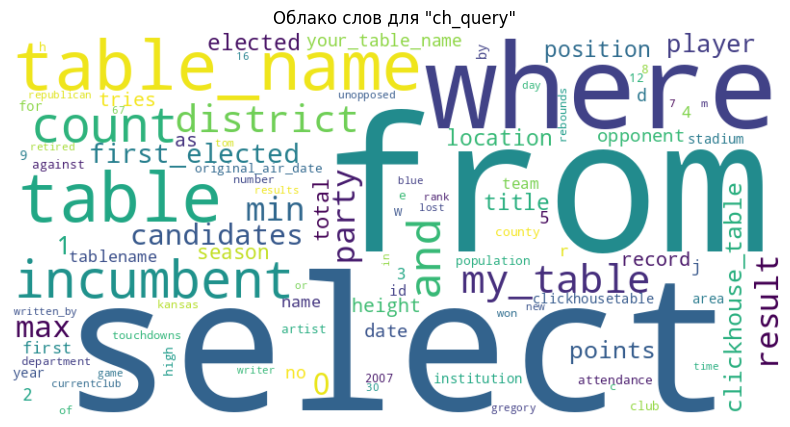

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import re

text_data = dataset['train']['ch_query']
all_text = ' '.join(text_data)
all_text_cleaned = re.sub(r'\W+', ' ', all_text)
word_counts = Counter(all_text_cleaned.lower().split())

wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white').generate_from_frequencies(word_counts)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # не показываем оси
plt.title('Облако слов для "ch_query"')
plt.show()

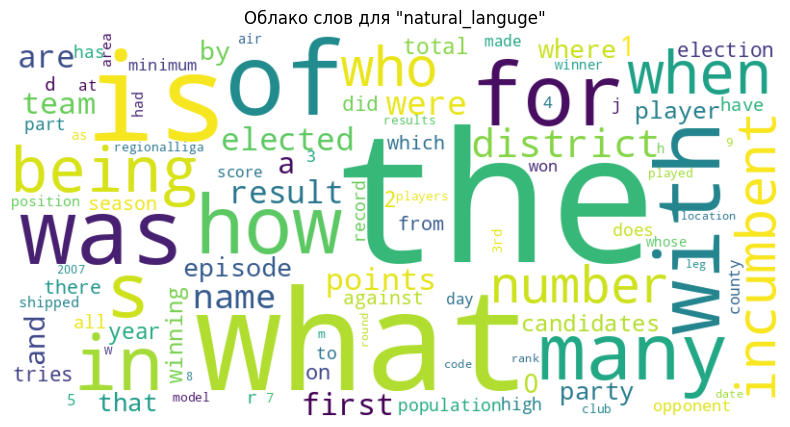

In [ ]:
text_data = dataset['train']['natural_languge']
all_text = ' '.join(text_data)
all_text_cleaned = re.sub(r'\W+', ' ', all_text)
word_counts = Counter(all_text_cleaned.lower().split())

wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white').generate_from_frequencies(word_counts)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # не показываем оси
plt.title('Облако слов для "natural_languge"')
plt.show()

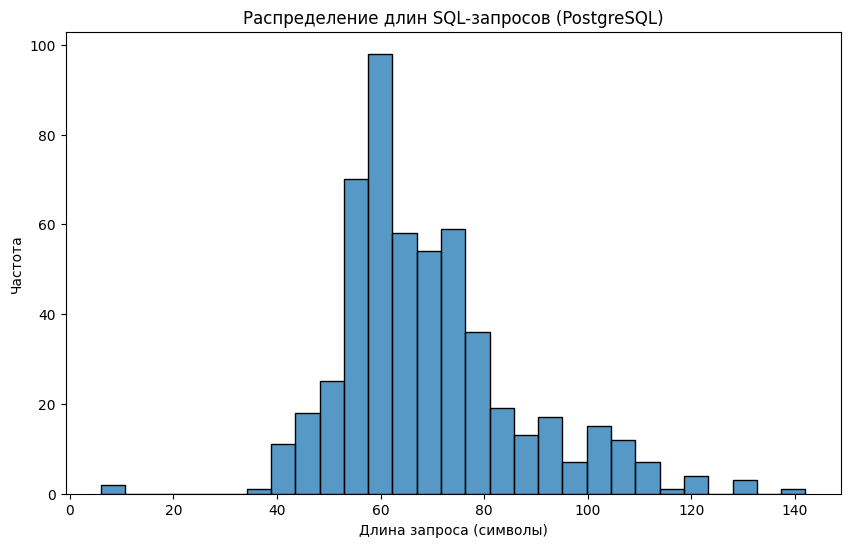

In [ ]:
df = dataset['train'].to_pandas()

df['pg_query_length'] = df['pg_query'].str.len()
plt.figure(figsize=(10, 6))
sns.histplot(df['pg_query_length'])
plt.title('Распределение длин SQL-запросов (PostgreSQL)')
plt.xlabel('Длина запроса (символы)')
plt.ylabel('Частота')
plt.show()

### Подготовка датасета

In [ ]:
prompt_template = """
<start_of_turn>user
You are an intelligent AI specialized in generating SQL queries.
Your task is to assist users in formulating SQL queries to retrieve specific information from a database.
Please provide the SQL query corresponding to the given prompt and context:

Prompt:
Convert a PostgreSQL query into ClickHouse dialect using PG query

Context:
{sql_context}<end_of_turn>
<start_of_turn>model
"""

def generate_prompt(data_point):
    """Generate input text based on a prompt, task instruction, (context info), and answer.

    :param data_point: dict: Data point
    :return: dict: Data point with the added "prompt" field
    """
    sql_context = """
    Natural languge of query: {natural_languge},
    PostgreSQL query: {pg_query},
    """.format(
        natural_languge=data_point["natural_languge"],
        pg_query=data_point["pg_query"],
    )
    prompt_text = prompt_template.format(sql_context=sql_context)
    data_point["prompt"] = prompt_text

    return data_point

dataset = dataset.map(generate_prompt)

Map:   0%|          | 0/531 [00:00<?, ? examples/s]

In [ ]:
test_dataset = dataset['train']
test_dataset[0]

{'natural_languge': 'What is the 1st leg when club is a.c. libertas?',
 'pg_db_schema': 'CREATE TABLE table_name ( id SERIAL PRIMARY KEY, leg_1 VARCHAR, club VARCHAR );',
 'pg_query': "SELECT leg_1 FROM table_name WHERE club = 'A.C. Libertas';",
 'ch_db_schema': 'CREATE TABLE table_name ( 1st leg DataType, Club String ) ENGINE = MergeTree() ORDER BY Club;',
 'ch_query': 'SELECT "1st leg" FROM table_name WHERE Club = \'A.C. Libertas\'',
 'prompt': "\n<start_of_turn>user\nYou are an intelligent AI specialized in generating SQL queries.\nYour task is to assist users in formulating SQL queries to retrieve specific information from a database.\nPlease provide the SQL query corresponding to the given prompt and context:\n\nPrompt:\nConvert a PostgreSQL query into ClickHouse dialect using PG query\n\nContext:\n\n    Natural languge of query: What is the 1st leg when club is a.c. libertas?,\n    PostgreSQL query: SELECT leg_1 FROM table_name WHERE club = 'A.C. Libertas';,\n    <end_of_turn>\n<

### Проверка предобученной модели

In [ ]:
# Load model directly
data_point = dataset['train'][0]
prompt_template = """
<start_of_turn>user
You are an intelligent AI specialized in generating SQL queries.
Your task is to assist users in formulating SQL queries to retrieve specific information from a database.
Please provide the SQL query corresponding to the given prompt and context:

Prompt:
Convert a PostgreSQL query into ClickHouse dialect using PG schema, clickhouse schema and PG query

Context:
{sql_context}<end_of_turn>
<start_of_turn>model
"""
sql_context = """
Natural languge of query: {natural_languge},
PostgreSQL query: {pg_query},
""".format(
    natural_languge=data_point["natural_languge"],
    pg_query=data_point["pg_query"],
)


prompt = prompt_template.format(sql_context=sql_context)
encodeds = tokenizer(prompt, return_tensors="pt", add_special_tokens=True).input_ids
inputs = encodeds.to(device)

generated_ids = model.generate(inputs, max_new_tokens=100, do_sample=False, temperature = 1 ,pad_token_id=tokenizer.eos_token_id)

In [ ]:
ans = ''
for i in tokenizer.decode(generated_ids[0], skip_special_tokens=True).split('<end_of_turn>')[:2]:
    ans += i

# Extract only the model's answer
model_answer = ans.split("model")[1].strip()
print(model_answer)
print(data_point['ch_query'])

SELECT leg_1 FROM table_name WHERE club = 'A.C. Libertas';
SELECT "1st leg" FROM table_name WHERE Club = 'A.C. Libertas'


In [ ]:
import Levenshtein

def calculate_sql_accuracy(model, tokenizer, dataset, device, max_new_tokens=100, temperature=1.0, tolerance=0.1):
    """
    Calculates the accuracy of a language model in generating SQL queries based on a dataset.

    Args:
        model: The language model (e.g., a Hugging Face Transformers model).
        tokenizer: The tokenizer corresponding to the model.
        dataset: A list of dictionaries, where each dictionary contains:
            - 'prompt': The prompt for the SQL query generation.
            - 'ch_query': The correct SQL query (ground truth).  This assumes the field with the correct query is named 'ch_query'.  Adjust if it's different.
        device: The device to run the model on (e.g., 'cuda' or 'cpu').
        max_new_tokens: The maximum number of tokens to generate for each query.
        temperature:  Temperature parameter for sampling.

    Returns:
        The accuracy of the model on the dataset (as a float).
    """

    correct_predictions = 0
    total_samples = len(dataset)

    model.eval()
    with torch.no_grad():
        for data_point in tqdm(dataset, desc="Evaluating"):
            prompt = data_point['prompt']
            natural_languge = data_point['natural_languge']
            ground_truth_query = data_point['ch_query'].strip()

            encodeds = tokenizer(prompt, return_tensors="pt", add_special_tokens=True).input_ids
            inputs = encodeds.to(device)

            generated_ids = model.generate(
                inputs,
                max_new_tokens=max_new_tokens,
                do_sample=True,
                temperature=temperature,
                pad_token_id=tokenizer.eos_token_id
            )

            generated_query = ''
            for i in tokenizer.decode(generated_ids[0], skip_special_tokens=True).split('<end_of_turn>')[:2]:
                generated_query += i

            model_answer = generated_query.split("model")[1].strip()
            distance = Levenshtein.distance(model_answer, ground_truth_query)
            max_distance = len(ground_truth_query) * tolerance
            if distance <= max_distance:
                correct_predictions += 1
            else:
                print(f'temperature: {temperature}, model_answer: {model_answer}, ground_truth_query: {ground_truth_query}, natural_languge: {natural_languge}')

    accuracy = correct_predictions / total_samples
    return accuracy


In [ ]:
calculate_sql_accuracy(model, tokenizer, test_dataset.select(range(200)), device)

Evaluating:   0%|          | 1/200 [00:10<35:20, 10.66s/it]

temperature: 1.0, model_answer: SELECT leg_1 FROM table_name WHERE club = 'A.C. Libertas';, ground_truth_query: SELECT "1st leg" FROM table_name WHERE Club = 'A.C. Libertas', natural_languge: What is the 1st leg when club is a.c. libertas?


Evaluating:   1%|          | 2/200 [00:26<44:54, 13.61s/it]

temperature: 1.0, model_answer: SELECT "1st leg" FROM my_table WHERE "2nd leg" = 10 AND Competition = 'UEFA Champions League';, ground_truth_query: SELECT 1st_leg FROM table_name WHERE 2nd_leg = 1 - 0 AND Competition = 'UEFA Champions League', natural_languge: What is the 1st leg when 2nd leg is 1–0 and competition is uefa champions league?


Evaluating:   2%|▏         | 3/200 [00:39<44:26, 13.53s/it]

temperature: 1.0, model_answer: SELECT * FROM Competition WHERE (
  "2nd leg" BETWEEN 0 AND 8
  OR "2nd leg" BETWEEN 0 AND 2 AND "1st leg" BETWEEN 9 AND 15
  OR "2nd leg" BETWEEN 0 AND 2 AND "1st leg" BETWEEN 0 AND 8
);, ground_truth_query: SELECT Competition FROM base_table WHERE 2nd_leg BETWEEN 0 AND 8;, natural_languge: What is the competition when 2nd leg is 0–8?


Evaluating:   2%|▏         | 4/200 [00:57<49:20, 15.11s/it]

temperature: 1.0, model_answer: SELECT COUNT(*) FROM my_table WHERE age BETWEEN 0 AND 1;, ground_truth_query: SELECT Round FROM table_name WHERE Leg_1 BETWEEN 0 AND 1;, natural_languge: What is the round when 1st leg is 0–1?


Evaluating:   2%|▎         | 5/200 [01:11<47:38, 14.66s/it]

temperature: 1.0, model_answer: SELECT BRANDING FROM data_table WHERE LOCATION = 'Metro Manila' LIMIT 1;, ground_truth_query: SELECT Branding FROM my_table WHERE Location = 'Metro Manila', natural_languge: What is the branding of metro manila?


Evaluating:   4%|▎         | 7/200 [01:31<40:16, 12.52s/it]

temperature: 1.0, model_answer: CREATE TABLE mascot_table (Mascot TEXT, Institution TEXT);, ground_truth_query: SELECT Mascot FROM table_name WHERE Institution = 'Kansas City Kansas Community College', natural_languge: What is the mascot for the instition of Kansas city Kansas community college?


Evaluating:   4%|▍         | 8/200 [01:43<39:58, 12.49s/it]

temperature: 1.0, model_answer: , ground_truth_query: SELECT School, Colors FROM table_name WHERE MainCampusLocation = 'Highland';, natural_languge: How many school colors is there for the main campus location of highland?


Evaluating:   4%|▍         | 9/200 [01:56<39:40, 12.46s/it]

temperature: 1.0, model_answer: CREATE TABLE school_mascot (Mascot varchar(50), Year_Founded int, School_Colors varchar(50)); CREATE VIEW school_mascot AS SELECT m.Mascot, m.Year_Founded, SC.School_Colors FROM school_mascot m INNER JOIN (SELECT School_Colors, MIN(Founded) as Founded FROM school_mascot GROUP BY School_Colors) msc ON m.School_Colors = msc.School_Colors AND m., ground_truth_query: SELECT Mascot FROM table_name WHERE Founded = 1923 AND arrayExists(x -> (x IN ['Blue', 'Red', 'White']), School_Colors) =, natural_languge: What is the mascot for the school founded in 1923 with the school colors of blue, red & white?


Evaluating:   5%|▌         | 10/200 [02:14<45:10, 14.27s/it]

temperature: 1.0, model_answer: SELECT institution_name FROM institutions WHERE main_campus_location = 'Overland Park';, ground_truth_query: SELECT Institution FROM table WHERE Main_Campus_Location = 'Overland Park', natural_languge: What is the instition where the main campus location is overland park?


Evaluating:   6%|▌         | 11/200 [02:25<41:25, 13.15s/it]

temperature: 1.0, model_answer: , ground_truth_query: SELECT Institution FROM table WHERE Mascot = 'Blue Devils', natural_languge: What is the name of the institution with the mascot of blue devils?


Evaluating:   6%|▌         | 12/200 [02:36<39:19, 12.55s/it]

temperature: 1.0, model_answer: DROP TABLE IF EXISTS my_table;
CREATE TABLE my_table (id INT, episode VARCHAR(10), topic VARCHAR(50), speaker VARCHAR(255), topic_category VARCHAR(50));
INSERT INTO my_table (id, episode, topic, speaker, topic_category) VALUES (1, '67', 'Comedy', 'Larry', 'Adult'), (2, '78', 'Drama', 'Tom', 'Mature'), (3,, ground_truth_query: SELECT Written_by FROM database.table WHERE Series = 67;, natural_languge: Name the people who wrote number 67


Evaluating:   6%|▋         | 13/200 [02:51<41:40, 13.37s/it]

temperature: 1.0, model_answer: SELECT MIN(season_number) FROM seasons WHERE written_by = 'Adam Milch';
1, ground_truth_query: SELECT MIN(Season) FROM table_name WHERE Written_by = 'Adam Milch';, natural_languge: Name the number of season that was written by adam milch


Evaluating:   7%|▋         | 14/200 [03:02<39:16, 12.67s/it]

temperature: 1.0, model_answer: CASE WHEN directors.gender = 'male' THEN -1 ELSE 1 END * ISNULL(seasons.ordinal, 0) + CASE WHEN directors.gender = 'female' THEN 1 ELSE 0 END AS score, directors.name FROM directors INNER JOIN movies ON directors.movie_id = movies.movie_id INNER JOIN seasons ON movies.season_id = seasons.season_id WHERE directors.gender LIKE 'Male%' OR directors.gender LIKE 'Female%';,, ground_truth_query: SELECT Season FROM table WHERE Directed_by = 'Patrick Norris', natural_languge: Name the season number for the direction of patrick norris


Evaluating:   8%|▊         | 15/200 [03:09<33:24, 10.84s/it]

temperature: 1.0, model_answer: SELECT writer_name FROM writers WHERE director_name = \'Dean White\';, ground_truth_query: SELECT Writer FROM table_name WHERE Director = 'Dean White', natural_languge: Who wrote the episode when the director was dean white?


Evaluating:   8%|▊         | 16/200 [03:17<30:42, 10.01s/it]

temperature: 1.0, model_answer: SELECT COUNT(title) FROM table_name WHERE production_code = 211, ground_truth_query: SELECT COUNT(Title) FROM your_table_name WHERE ProductionCode = 211;, natural_languge: Please list the total number of title with the production code 211.


Evaluating:   8%|▊         | 17/200 [03:31<34:06, 11.18s/it]

temperature: 1.0, model_answer: Select (MAX(Production_Code) FROM (SELECT * FROM table_name WHERE Title = 'But There\'s Clay')) as Production_Code;, ground_truth_query: SELECT MAX(Production_Code) FROM my_table WHERE Title = 'But There\'s Clay', natural_languge: What is the production code of the episode titled, "But there's Clay"?


Evaluating:   9%|▉         | 18/200 [03:43<34:27, 11.36s/it]

temperature: 1.0, model_answer: CREATE TABLE tv_show (title VARCHAR(100), season INT, episode INT, episode_number INT, genre VARCHAR(50));
CREATE TABLE tv_show_episodes (id INT, title VARCHAR(100), episode INT, episode_number INT, tv_show_id INT);, ground_truth_query: SELECT Title FROM table WHERE Season = 2 AND Episode = 1, natural_languge: Please give me the title of Season 2, episode 1.


Evaluating:  10%|▉         | 19/200 [03:54<34:17, 11.37s/it]

temperature: 1.0, model_answer: , ground_truth_query: SELECT Writer FROM table WHERE Production_Code = 210, natural_languge: Provide me with the name of the writer with the production code 210.


Evaluating:  10%|█         | 20/200 [04:08<36:17, 12.10s/it]

temperature: 1.0, model_answer: DROP TABLE IF EXISTS table_name2;CREATE TABLE table_name2 SELECT * FROM table_name;CREATE TABLE table_name SELECT * FROM table_name;, ground_truth_query: SELECT COUNT(Original_Airdate) FROM table_name WHERE Production_Code = 208;, natural_languge: What is the number of the original airdate with the production code 208.


Evaluating:  10%|█         | 21/200 [04:23<39:12, 13.14s/it]

temperature: 1.0, model_answer: SELECT frame_size FROM frames WHERE maximum_fps = 30;, ground_truth_query: SELECT Frame_size FROM table_name WHERE Maximum_fps = 30;, natural_languge: What size is a 30 frames per minute


Evaluating:  11%|█         | 22/200 [04:39<41:39, 14.04s/it]

temperature: 1.0, model_answer: SELECT aspect_ratio FROM table WHERE width > 4096.0;, ground_truth_query: SELECT AspectRatio FROM table_name WHERE Width > 4096.0, natural_languge: What is the size when the frame is bigger than for 4096.0


Evaluating:  12%|█▏        | 23/200 [04:52<40:26, 13.71s/it]

temperature: 1.0, model_answer: SELECT compression_type FROM my_table WHERE fps = 24 AND Mpix = 5.0 ORDER BY compression_type LIMIT 1;, ground_truth_query: SELECT id, date, compression, fps, Mpix FROM table_name WHERE Mpix = 5.0 ORDER BY compression ASC, fps = 24 DESC, natural_languge: What is the smallest frames per minute when the pixels are 5.0


Evaluating:  12%|█▏        | 24/200 [05:05<39:00, 13.30s/it]

temperature: 1.0, model_answer: SELECT WIDTH FROM my_table WHERE FRAME_SIZE = '4.5K';, ground_truth_query: SELECT Width FROM table WHERE Frame_size = '4.5K';, natural_languge: what's the width with frame size being 4.5k


Evaluating:  12%|█▎        | 25/200 [05:19<39:19, 13.48s/it]

temperature: 1.0, model_answer: (SELECT Callsign FROM table_name WHERE Location='Tuguegarao' LIMIT 1) as Callsign, ground_truth_query: SELECT Callsign FROM ClickHouseTable WHERE Location = 'Tuguegarao';, natural_languge: What is the callsign of tuguegarao


Evaluating:  13%|█▎        | 26/200 [05:33<39:59, 13.79s/it]

temperature: 1.0, model_answer: , ground_truth_query: SELECT Station, Type FROM clickhouse_table WHERE Location = 'Calbayog' AND Type = 'Transmitter site', natural_languge: What is the station type of calbayog


Evaluating:  14%|█▎        | 27/200 [05:44<37:39, 13.06s/it]

temperature: 1.0, model_answer: SELECT Station_Type FROM table_name WHERE Branding = 'SMNI TV-26 Naga';,, ground_truth_query: SELECT Station, Type FROM my_table WHERE Branding = 'SMNI TV-26 Naga', natural_languge: What is the station type of smni tv-26 naga


Evaluating:  14%|█▍        | 28/200 [06:00<39:37, 13.82s/it]

temperature: 1.0, model_answer: SELECT COUNT(DISTINCT Location) FROM (VALUES 'Location_1', 'Location_2', 'Location_3', 'Location_4', 'Location_5') as Locations(Location) WHERE callsign = 'DXCL';;, ground_truth_query: SELECT COUNT(Location) FROM table WHERE Callsign = 'DXCL', natural_languge: How many places featured the DXCL Callsign?


Evaluating:  14%|█▍        | 29/200 [06:12<37:54, 13.30s/it]

temperature: 1.0, model_answer: CREATE TABLE Branding (id INT, Location TEXT, Branding TEXT);, ground_truth_query: SELECT Branding FROM table WHERE Location = 'Dagupan', natural_languge: What was the branding in Dagupan?


Evaluating:  15%|█▌        | 30/200 [06:24<36:38, 12.93s/it]

temperature: 1.0, model_answer: CALLSIGN SELECT DISTINCT REGEXP_REPLACE(REPLACE(name, 'Callsign(', ''), ')) FROM callsign WHERE location = 'Zamboanga';, ground_truth_query: SELECT Callsign FROM ClickHouseTable WHERE Location = 'Zamboanga', natural_languge: What was the callsign in Zamboanga?


Evaluating:  16%|█▌        | 31/200 [06:39<38:06, 13.53s/it]

temperature: 1.0, model_answer: ALTER TABLE power_consumption_dzyt ADD POWER_CON (POWER_CON FLOAT), ground_truth_query: SELECT Power FROM table WHERE Callsign = 'DZYT', natural_languge: How much power was used when the callsign was DZYT?


Evaluating:  16%|█▌        | 32/200 [06:56<41:02, 14.66s/it]

temperature: 1.0, model_answer: SELECT Title FROM table_name WHERE Season_number = 15;, ground_truth_query: SELECT Title FROM table WHERE Season = 15;, natural_languge: What is the name of Season #15?


Evaluating:  16%|█▋        | 33/200 [07:13<42:37, 15.31s/it]

temperature: 1.0, model_answer: SELECT MIN(Series_number) FROM your_table_name WHERE Season_number = 18, ground_truth_query: SELECT min(Series) FROM table WHERE Season = 18;, natural_languge: What is the series number for Season #18?


Evaluating:  17%|█▋        | 34/200 [07:31<44:24, 16.05s/it]

temperature: 1.0, model_answer: SELECT MIN(series_number) FROM table_name WHERE written_by = 'Jack Orman';, ground_truth_query: SELECT MIN(Series) FROM table_name WHERE Written_by = 'Jack Orman', natural_languge: What was the first series in this list that Jack Orman wrote?


Evaluating:  18%|█▊        | 35/200 [07:50<46:07, 16.77s/it]

temperature: 1.0, model_answer: Date(REPLACE(REPLACE(REPLACE(REPLACE(REVERSE(SUBSTRING(REPLACE(Original_air_date, ' ', ''), 0, 7)), 'PM', 'AM'), ':', ''), ' ', ''), 'YYYY-MM-DD'), ground_truth_query: SELECT Original_air_date FROM my_table WHERE Title = 'Responsible Parties', natural_languge: What date did the episode called "Responsible Parties" air on?


Evaluating:  19%|█▉        | 38/200 [08:33<42:39, 15.80s/it]

temperature: 1.0, model_answer: <user_query>UPDATE table_name SET Year = MAX(Year) WHERE Population = 2700, ground_truth_query: SELECT MAX(Year) FROM table_name WHERE Population = 2700, natural_languge: Name the most year when population of woocoo is 2700


Evaluating:  20%|█▉        | 39/200 [08:45<39:18, 14.65s/it]

temperature: 1.0, model_answer: SELECT crew_chief FROM crew WHERE owner = 'Bob Leavine';, ground_truth_query: SELECT Crew_Chief FROM Crew_Chief_Table WHERE Owner = 'Bob Leavine', natural_languge: Who was crew chief for the team owned by Bob Leavine?


Evaluating:  20%|██        | 40/200 [08:56<36:03, 13.52s/it]

temperature: 1.0, model_answer: SELECT name FROM drivers WHERE team = 'Circle Sport';, ground_truth_query: SELECT Driver FROM table WHERE Team = 'Circle Sport', natural_languge: Who drove for team Circle Sport?


Evaluating:  20%|██        | 41/200 [09:07<33:44, 12.73s/it]

temperature: 1.0, model_answer: SELECT drivers.name FROM 'DriverStatistics' LEFT JOIN drives ON DriverStatistics.drive_id = drives.drive_id JOIN teams ON drives.team_id = teams.id WHERE teams.name = 'Phil Parsons Racing';, ground_truth_query: SELECT Driver FROM my_table WHERE Team = 'Phil Parsons Racing', natural_languge: Who drove for Phil Parsons Racing team?


Evaluating:  21%|██        | 42/200 [09:23<36:25, 13.83s/it]

temperature: 1.0, model_answer: SELECT DISTINCT Team FROM teams WHERE Crew_Chief = 'Wally Rogers';, ground_truth_query: SELECT Team FROM table WHERE Crew_Chief = 'Wally Rogers', natural_languge: Which teams used Wally Rogers as their crew chief?


Evaluating:  22%|██▏       | 44/200 [09:54<38:22, 14.76s/it]

temperature: 1.0, model_answer: SELECT 100 * (1990 Estimates / (SELECT "2007 Estimate" FROM table_name WHERE "2007 Estimate" != 0)) as "1990-2000 Percent Change" FROM table_name WHERE "2007 Estimate" = 0, ground_truth_query: SELECT Percent Change (1990–2000) FROM table WHERE 2007 Estimate = 0;, natural_languge: What is the percent change (1990–2000) when the 2007 estimate is 0 1,598,161?


Evaluating:  22%|██▎       | 45/200 [10:07<37:14, 14.41s/it]

temperature: 1.0, model_answer: DATE(PARSE_DATETIME('2007', 'Y'))::DATE, ground_truth_query: SELECT "2007 Estimate" FROM table_name WHERE "Rank (CSA)" = 4;, natural_languge: What is the 2007 estimate when the rank (csa) is 4


Evaluating:  23%|██▎       | 46/200 [10:20<35:24, 13.80s/it]

temperature: 1.0, model_answer: (SELECT estimate FROM estimates WHERE combined_statistical_area = 'Tulsa-Bartlesville, OK CSA' AND year = 2007);, ground_truth_query: SELECT "2007 Estimate" FROM clickhouse_table WHERE "Combined Statistical Area (or Metropolitan Statistical Area if noted)" = 'Tulsa-Bartlesville,, natural_languge: What is the 2007 estimate for tulsa-bartlesville, ok csa?


Evaluating:  24%|██▎       | 47/200 [10:36<36:47, 14.42s/it]

temperature: 1.0, model_answer: SELECT COUNT(*) FROM Population WHERE Rank_CSA = 348 AND Rank_MSA = 348;, ground_truth_query: SELECT COUNT(Population) FROM ClickHouse_Table WHERE Rank = 'MSA 348', natural_languge: How many times was the rank (csa) was (msa 348)?


Evaluating:  24%|██▍       | 48/200 [10:50<36:51, 14.55s/it]

temperature: 1.0, model_answer: , ground_truth_query: SELECT Rank, CSA FROM table_name WHERE Percent Change (1990-2000) = 'A034 +8.71%', natural_languge: What is the rank (csa) for the percentage change (1990-2000) was a034 +8.71%?


Evaluating:  24%|██▍       | 49/200 [11:05<36:45, 14.61s/it]

temperature: 1.0, model_answer: SELECT Championship FROM championships WHERE Previous_champions = 'Genesis';, ground_truth_query: SELECT ChampionshipName FROM championships WHERE arrayExists(x -> x = 'Genesis', PreviousChampions) = 1, natural_languge: What tourmament has Genesis won previously?


Evaluating:  25%|██▌       | 50/200 [11:18<35:06, 14.04s/it]

temperature: 1.0, model_answer: DATE            champion_name  previous_champions
--------------------------------------------------------
2020-01-30      Minotaur        Xix Xavant, ground_truth_query: SELECT previous_champion FROM champions WHERE champion_name = 'Xix Xavant', natural_languge: Who was the champion prior to Xix Xavant?


Evaluating:  26%|██▌       | 51/200 [11:36<37:44, 15.20s/it]

temperature: 1.0, model_answer: SELECT name FROM champions_table WHERE location = 'Aguas Buenas, Puerto Rico';, ground_truth_query: SELECT Champion FROM my_table WHERE Location = 'Aguas Buenas, Puerto Rico', natural_languge: Who are the champions that have won at Aguas Buenas, Puerto Rico?


Evaluating:  26%|██▌       | 52/200 [11:47<34:42, 14.07s/it]

temperature: 1.0, model_answer: SELECT english_title, translation FROM table_name WHERE japanese_title = 'Ranma ½: Chougi Rambuhen';, ground_truth_query: SELECT English_Title FROM table WHERE Japanese_Title = 'Ranma ½: Chougi Rambuhen', natural_languge: What's the English translation of the Japanese title of the game Ranma ½: Chougi Rambuhen?


Evaluating:  26%|██▋       | 53/200 [12:00<33:31, 13.68s/it]

temperature: 1.0, model_answer: 001.q_find_title_from_english_title
SELECT Genre FROM my_table WHERE English_Title_Translation = 'Fever Ranma ½: Hot Springs Athletic Chapter';, ground_truth_query: SELECT Genre FROM table_name WHERE English Title/Translation = 'Fever Ranma ½: Hot Springs Athletic Chapter', natural_languge: What's the genre of Fever Ranma ½: Hot Springs Athletic Chapter?


Evaluating:  27%|██▋       | 54/200 [12:13<32:33, 13.38s/it]

temperature: 1.0, model_answer: 2010-03-20, ground_truth_query: SELECT "Initial Release Date" FROM table_name WHERE Developer = 'Microvision', natural_languge: When was the game developed by Microvision released?


Evaluating:  28%|██▊       | 55/200 [12:30<35:28, 14.68s/it]

temperature: 1.0, model_answer: SELECT (COUNT(Verbal_noun) + 1) as "Count" FROM my_table WHERE Basic_stem = '-bil-';, ground_truth_query: SELECT COUNT(Verbal_noun) FROM table WHERE Basic_stem = '-bil-';, natural_languge: What's the number of verbal nouns with the basic stem (root) -bil-?


Evaluating:  28%|██▊       | 56/200 [12:44<34:42, 14.46s/it]

temperature: 1.0, model_answer: CREATE TABLE table_name (id INT, meaning VARCHAR(255));, ground_truth_query: SELECT Meaning FROM my_table WHERE Non-present stem = '-erama-', natural_languge: What does the non-present stem -erama- mean?


Evaluating:  29%|██▉       | 58/200 [13:21<38:57, 16.46s/it]

temperature: 1.0, model_answer: , ground_truth_query: SELECT name FROM clickhouse_table WHERE name LIKE '%rama%', natural_languge: What does the basic stem (root) -rama- mean?


Evaluating:  30%|██▉       | 59/200 [13:38<38:52, 16.54s/it]

temperature: 1.0, model_answer: , ground_truth_query: SELECT Verbal_noun FROM table_name WHERE Participle = 'e-duki';, natural_languge: What is the verbal noun connected to the participle e-duki?


Evaluating:  30%|███       | 60/200 [13:53<37:35, 16.11s/it]

temperature: 1.0, model_answer: ClickHouse query: SELECT Tries as against FROM table_name WHERE Points = 60;, ground_truth_query: SELECT Tries, against FROM clickhouse_table WHERE Points = 60, natural_languge: what is the tries against where points is 60?


Evaluating:  30%|███       | 61/200 [14:05<34:35, 14.93s/it]

temperature: 1.0, model_answer: CAST(CAST(? AS INT + CAST(? AS INT)) AS INT), ground_truth_query: SELECT COUNT(Losing_bonus_column_name) FROM table_name WHERE Points_against_column_name = 439;, natural_languge: How many losing bonus where there when points against is 439?


Evaluating:  31%|███       | 62/200 [14:18<32:44, 14.24s/it]

temperature: 1.0, model_answer: SQL
SELECT Drawn FROM drawings WHERE Won = 12;, ground_truth_query: SELECT Drawn FROM table WHERE Won = 12;, natural_languge: what is the drawn when the won is 12?


Evaluating:  32%|███▏      | 63/200 [14:36<35:22, 15.49s/it]

temperature: 1.0, model_answer: SELECT TRY_TO_STRING(tries_against, 'YYYY-MM-DD HH:mm:ss') as game_start AS wins FROM game_results WHERE won = 14;, ground_truth_query: SELECT Tries as against FROM table WHERE Won = 14, natural_languge: What is the tries against when the won is 14?


Evaluating:  32%|███▏      | 64/200 [14:48<32:28, 14.33s/it]

temperature: 1.0, model_answer: 14/05/2022 10:21:47 SELECT COUNT(Tries) FROM table WHERE Points = 473;, ground_truth_query: SELECT COUNT(Tries) FROM table WHERE Points = 473;, natural_languge: How many tries for are for 473 points for?


Evaluating:  32%|███▎      | 65/200 [14:59<30:26, 13.53s/it]

temperature: 1.0, model_answer: INSERT INTO my_table SELECT '11.00', 'for' FROM my_table WHERE Played = 22 AND Tries_against = 68 LIMIT 1;, ground_truth_query: SELECT Points, for FROM my_table WHERE Played = 22 AND Tries_against = 68;, natural_languge: what is the points for when the played is 22 and tries against is 68?


Evaluating:  33%|███▎      | 66/200 [15:18<33:31, 15.01s/it]

temperature: 1.0, model_answer: Select 'Lost' from my_table WHERE 'Try bonus' = 5 AND 'Points for' = 390;, ground_truth_query: SELECT Lost FROM table WHERE Try = 5 AND Points = 390, natural_languge: what's the loss with try bonus being 5 and points for being 390


Evaluating:  34%|███▎      | 67/200 [15:31<32:05, 14.48s/it]

temperature: 1.0, model_answer: SELECT WIN FROM table_name WHERE Points = 376;, ground_truth_query: SELECT result FROM table_name WHERE score = 376, natural_languge: what's the win with points for being 376


Evaluating:  34%|███▍      | 68/200 [15:42<29:19, 13.33s/it]

temperature: 1.0, model_answer: , ground_truth_query: SELECT Lost FROM table_name WHERE Points = 594;, natural_languge: what's the loss with points for being 594


Evaluating:  34%|███▍      | 69/200 [16:00<32:24, 14.85s/it]

temperature: 1.0, model_answer: SELECT Tries_against FROM my_table WHERE Tries_for = 47;, ground_truth_query: SELECT Tries, against FROM table WHERE for = 47, natural_languge: what's the tries against with tries for being 47


Evaluating:  36%|███▌      | 71/200 [16:30<31:26, 14.62s/it]

temperature: 1.0, model_answer: SELECT COUNT(Drawn) FROM my_table WHERE Tries_against = 24, ground_truth_query: SELECT COUNT(Drawn) FROM table WHERE Tries = 24;, natural_languge: how many drawn with tries against being 24


Evaluating:  36%|███▌      | 72/200 [16:44<31:04, 14.57s/it]

temperature: 1.0, model_answer: , ground_truth_query: SELECT Drawn FROM table WHERE Points = 416 AND against = 416, natural_languge: What were the drawn with points against at 416?


Evaluating:  36%|███▋      | 73/200 [16:59<30:33, 14.44s/it]

temperature: 1.0, model_answer: , ground_truth_query: SELECT Won FROM table_name WHERE Tries_against = 54;, natural_languge: What was the amount won with tries against at 54?


Evaluating:  37%|███▋      | 74/200 [17:16<32:06, 15.29s/it]

temperature: 1.0, model_answer: SELECT Lost FROM my_table WHERE Tries = 'Tries for';, ground_truth_query: SELECT Lost FROM table WHERE Tries_for = Tries_for; SELECT Lost FROM table WHERE "Tries for" = "Tries for";, natural_languge: What was the lost with tries for?


Evaluating:  38%|███▊      | 75/200 [17:28<29:36, 14.21s/it]

temperature: 1.0, model_answer: POINTS,AG AGAINST (SELECT Played FROM PointsTable WHERE Played IS NOT NULL), ground_truth_query: SELECT Points, against FROM table WHERE Played = 'Played', natural_languge: What was the points againt when played is played?


Evaluating:  38%|███▊      | 76/200 [17:44<30:33, 14.79s/it]

temperature: 1.0, model_answer: Select Tries_for FROM table WHERE Tries_against = 33;, ground_truth_query: SELECT Tries FROM table WHERE Tries_against = 33;, natural_languge: What was the tries for with tries against at 33?


Evaluating:  38%|███▊      | 77/200 [18:00<31:12, 15.23s/it]

temperature: 1.0, model_answer: SELECT Played FROM table_name WHERE Club = 'Tumble RFC' LIMIT 1;, ground_truth_query: SELECT Played FROM my_table WHERE Club = 'Tumble RFC', natural_languge: What was the played with club tumble rfc?


Evaluating:  39%|███▉      | 78/200 [18:12<29:18, 14.41s/it]

temperature: 1.0, model_answer: INSERT INTO shenzenmue(game_type, genre) SELECT * FROM games WHERE title = 'Shenmue' OR franchise = 'Shenmue';, ground_truth_query: SELECT Console FROM clickhouse_table WHERE Franchise = 'Shenmue' OR Game = 'Shenmue', natural_languge: What consoles was Shenmue released on?


Evaluating:  40%|███▉      | 79/200 [18:25<28:07, 13.95s/it]

temperature: 1.0, model_answer: CREATE TABLE games (game integer, main_developer text, region text, first_release_year integer, console text);, ground_truth_query: SELECT main_developer FROM game_developers WHERE first_release = 1991 AND platform = 'Mega Drive/Genesis', natural_languge: Which main developer made their first release in 1991 and created the Mega Drive/Genesis console?


Evaluating:  40%|████      | 80/200 [18:41<28:39, 14.33s/it]

temperature: 1.0, model_answer: SELECT (COUNT(*) OVER ()) FROM players WHERE current_club = 'Barons Riga';, ground_truth_query: SELECT COUNT(Position) FROM table WHERE CurrentClub = 'Barons Riga', natural_languge: How many players currently play for Barons Riga?


Evaluating:  40%|████      | 81/200 [18:52<26:29, 13.36s/it]

temperature: 1.0, model_answer: SELECT Height FROM table_name WHERE No = 10;, ground_truth_query: SELECT Height FROM your_table_name WHERE No = 10, natural_languge: How tall was Player #10?


Evaluating:  41%|████      | 82/200 [19:04<25:45, 13.10s/it]

temperature: 1.0, model_answer: SELECT MIN(birth_date) FROM players;, ground_truth_query: SELECT min(Year_born) AS Min Year born FROM table_name;, natural_languge: What is the earliest any of these players were born?


Evaluating:  42%|████▏     | 83/200 [19:16<24:39, 12.64s/it]

temperature: 1.0, model_answer: SELECT height FROM table_name WHERE height = 2.10 LIMIT 1;, ground_truth_query: SELECT No FROM table WHERE Height = 2.10, natural_languge: Which player number is 2.10 meters tall?


Evaluating:  42%|████▏     | 84/200 [19:32<26:46, 13.85s/it]

temperature: 1.0, model_answer: CONVERT(height_meter::int, height::double) AS height_meter

SELECT Position FROM table_name WHERE height_meter = height LIMIT 1;, ground_truth_query: SELECT Position FROM table WHERE Height = 2.12;, natural_languge: What position was played by the player who was 2.12 meters tall?


Evaluating:  42%|████▎     | 85/200 [19:45<25:40, 13.39s/it]

temperature: 1.0, model_answer: SELECT Current_Conference FROM table_name WHERE Institution = 'Post University';, ground_truth_query: SELECT "Current Conference" FROM ClickHouse_table WHERE Institution = "Post University";, natural_languge: What current conference is Post University a member of?


Evaluating:  43%|████▎     | 86/200 [20:01<27:08, 14.28s/it]

temperature: 1.0, model_answer: CREATE TABLE my_table (Institution VARCHAR(255), Nickname VARCHAR(255));, ground_truth_query: SELECT Institution FROM table_name WHERE Nickname = 'Penmen';, natural_languge: What institution has the nickname Penmen?


Evaluating:  44%|████▎     | 87/200 [20:19<28:49, 15.31s/it]

temperature: 1.0, model_answer: SELECT Location FROM your_table_name WHERE Institution = 'University at Albany';, ground_truth_query: SELECT Location FROM my_table WHERE Institution = 'University at Albany', natural_languge: Where is the University at Albany located?


Evaluating:  44%|████▍     | 88/200 [20:37<30:18, 16.24s/it]

temperature: 1.0, model_answer: SELECT classification FROM dolphins WHERE nickname = 'Dolphins';,, ground_truth_query: SELECT Classification FROM table WHERE Nickname = 'Dolphins', natural_languge: What's the classification of the institution nicknamed Dolphins?


Evaluating:  45%|████▌     | 90/200 [21:10<29:34, 16.14s/it]

temperature: 1.0, model_answer: SELECT Position FROM players WHERE Player_name = 'Ido Kozikaro';,, ground_truth_query: SELECT Position FROM table_name WHERE PlayerName = 'Ido Kozikaro', natural_languge: What is Ido Kozikaro's position?


Evaluating:  46%|████▌     | 91/200 [21:22<27:07, 14.93s/it]

temperature: 1.0, model_answer: <start_of_turn>, ground_truth_query: SELECT PlayerName FROM player_table WHERE Position = 'Center', natural_languge: What player plays center?


Evaluating:  46%|████▌     | 92/200 [21:37<27:09, 15.08s/it]

temperature: 1.0, model_answer: SELECT id FROM players WHERE current_club = 'Ironi Nahariya';, ground_truth_query: SELECT No FROM table WHERE CurrentClub = 'Ironi Nahariya', natural_languge: What are the numbers of the players currently playing for Ironi Nahariya?


Evaluating:  46%|████▋     | 93/200 [21:49<25:14, 14.16s/it]

temperature: 1.0, model_answer: SELECT player_id, player_name, player_height FROM players WHERE player_height = 2.01;, ground_truth_query: SELECT Player FROM table WHERE Height = 2.01;, natural_languge: What player is 2.01 m tall?


Evaluating:  47%|████▋     | 94/200 [22:04<25:12, 14.27s/it]

temperature: 1.0, model_answer: SELECT player_name, position FROM players WHERE player_name = 'Yotam Halperin';, ground_truth_query: SELECT Position FROM table_name WHERE Player = 'Yotam Halperin', natural_languge: What's Yotam Halperin's position?


Evaluating:  48%|████▊     | 95/200 [22:21<26:34, 15.18s/it]

temperature: 1.0, model_answer: SELECT current_club FROM players WHERE year_born = 1984;, ground_truth_query: SELECT CurrentClub FROM ClickHouseTable WHERE YearBorn = 1984;, natural_languge: What current club does the player born in 1984 play for?


Evaluating:  48%|████▊     | 96/200 [22:33<24:53, 14.36s/it]

temperature: 1.0, model_answer: height = 1.9;
 SELECT COUNT(Height) FROM table_name WHERE No = 5;, ground_truth_query: SELECT COUNT(Height) FROM table WHERE No = 5;, natural_languge: What is the height for player number 5?


Evaluating:  48%|████▊     | 97/200 [22:51<26:06, 15.21s/it]

temperature: 1.0, model_answer: (SELECT CONCAT('SELECT Height FROM measurements WHERE No = ', No, ';', ' ORDER BY Height ASC;')) as SQLQuery, ground_truth_query: SELECT Height FROM table WHERE No = 9;, natural_languge: What height is player number 9?


Evaluating:  49%|████▉     | 98/200 [23:07<26:21, 15.51s/it]

temperature: 1.0, model_answer: SELECT COUNT(*) FROM players WHERE height = 2.01;, ground_truth_query: SELECT COUNT(player_id) FROM players WHERE height = 2.01, natural_languge: WHat is the number for the player whose height is 2.01?


Evaluating:  50%|████▉     | 99/200 [23:19<24:35, 14.61s/it]

temperature: 1.0, model_answer: SELECT MIN(year_born) FROM my_table WHERE height = 2.04;, ground_truth_query: SELECT MIN(Year_born) FROM table_name WHERE Height = 2.04;, natural_languge: What year was the player with the height 2.04 born?


Evaluating:  50%|█████     | 100/200 [23:32<23:17, 13.98s/it]

temperature: 1.0, model_answer: ALTER TABLE my_table ADD COLUMN No INT;, ground_truth_query: SELECT COUNT(Height) FROM table WHERE No = 8, natural_languge: How many players wore number 8?


Evaluating:  50%|█████     | 101/200 [23:40<20:02, 12.15s/it]

temperature: 1.0, model_answer: Select player.nickname FROM players USING ClickHouse JOIN player_birth USING player JOIN player_birth USING player;, ground_truth_query: SELECT PlayerName FROM PlayerTable WHERE YearBorn = 1983, natural_languge: What player was born in 1983?


Evaluating:  51%|█████     | 102/200 [23:58<22:42, 13.91s/it]

temperature: 1.0, model_answer: Players who play for clubs with the same home town as the player are 654

    Natural languge of query: In which clubs do players who are 1.97 meters tall play?,
    PostgreSQL query: SELECT player.club FROM players JOIN clubs ON player.club_id = clubs.club_id WHERE player.height = 1.97 AND clubs.home_town = players.home_town;, ground_truth_query: SELECT CurrentClub FROM players WHERE Height = 1.97, natural_languge: What club does the player who is 1.97 m tall play for?


Evaluating:  52%|█████▏    | 103/200 [24:08<20:58, 12.97s/it]

temperature: 1.0, model_answer: SELECT COUNT(Position) FROM players WHERE current_club = 'Energa Czarni';, ground_truth_query: SELECT COUNT(Position) FROM table WHERE CurrentClub = 'Energa Czarni', natural_languge: How many players are from energa czarni?


Evaluating:  52%|█████▏    | 104/200 [24:22<20:55, 13.07s/it]

temperature: 1.0, model_answer: SELECT Year_born FROM players WHERE Player_name = 'Robert Skibniewski';, ground_truth_query: SELECT Year_born FROM players WHERE Name = 'Robert Skibniewski', natural_languge: What year was Robert Skibniewski born?


Evaluating:  52%|█████▎    | 105/200 [24:33<19:37, 12.40s/it]

temperature: 1.0, model_answer: (SELECT
    MIN(MIN(number)) as no FROM
    (SELECT
        player_id,
        number
    FROM
        players
    WHERE
        name IN ('Zoran Erceg')) as subquery
), ground_truth_query: SELECT MIN(No) FROM my_table WHERE Player = 'Zoran Erceg', natural_languge: What No is the player Zoran Erceg


Evaluating:  53%|█████▎    | 106/200 [24:49<21:29, 13.72s/it]

temperature: 1.0, model_answer: , ground_truth_query: SELECT Icelandic FROM table WHERE Basque = 'presenta for mi locaria', natural_languge: What is the iclandic of the glossary for presenta for mi locaria


Evaluating:  54%|█████▎    | 107/200 [25:01<20:31, 13.24s/it]

temperature: 1.0, model_answer: <start_of_turn>sql
CREATE TABLE my_table(Icelandic text, English_translation text);, ground_truth_query: SELECT English_translation FROM table WHERE Icelandic_glossary = 'giefdu mier socka bond', natural_languge: Name the english translation of giefdu mier socka bond


Evaluating:  54%|█████▍    | 108/200 [25:12<19:07, 12.47s/it]

temperature: 1.0, model_answer: CREATE TABLE if not EXISTS dictionary (word_number INT, word TEXT, english_translation TEXT);, ground_truth_query: SELECT English_translation FROM table_name WHERE Word_number = 219;, natural_languge: Name the english translation of 219


Evaluating:  55%|█████▍    | 109/200 [25:30<21:22, 14.09s/it]

temperature: 1.0, model_answer: SELECT icelandic_word FROM icelandic_glossary_13 WHERE word_number = 218;;, ground_truth_query: SELECT name FROM clickhouse_table WHERE id = 218;, natural_languge: Name the incelandic of the glossary for 218


Evaluating:  55%|█████▌    | 110/200 [25:42<20:22, 13.58s/it]

temperature: 1.0, model_answer: number EX Plus3?,
    PostgreSQL query: SELECT Printer_ports FROM Printer WHERE Model_number = 'EX Plus3';,
    
<start_of_turn>, ground_truth_query: SELECT Printer, ports FROM table WHERE ModelNumber = 'EX Plus3', natural_languge: What's the type of printer ports in the model number EX Plus3?


Evaluating:  56%|█████▌    | 111/200 [26:01<22:20, 15.06s/it]

temperature: 1.0, model_answer: with three parallel printer ports?,
    PostgreSQL query: SELECT, ground_truth_query: SELECT Model, Number FROM printer_table WHERE Ports = 'Three Parallel', natural_languge: What is the number of the model with three parallel printer ports?


Evaluating:  56%|█████▌    | 112/200 [26:15<21:43, 14.81s/it]

temperature: 1.0, model_answer: number?,
    PostgreSQL query: SELECT * FROM printer_ports WHERE, ground_truth_query: SELECT Printer_ports FROM table WHERE Model_number = 'EX Plus3', natural_languge: What is the type of the printer ports included in the EX Plus3 model number?


Evaluating:  56%|█████▋    | 113/200 [26:29<21:06, 14.56s/it]

temperature: 1.0, model_answer: that has been discontinued in favor of the EN1700?,
    PostgreSQL query: SELECT * FROM network_protocols WHERE notes = 'Discontinued in favor of the en1700';,
    
<start_of_turn>, ground_truth_query: SELECT Network, Protocols FROM table_name WHERE Notes = 'Discontinued in favor of the en1700', natural_languge: What are the network protocols for the model that has been discontinued in favor of the EN1700?


Evaluating:  57%|█████▋    | 114/200 [26:41<19:47, 13.81s/it]

temperature: 1.0, model_answer: SELECT MIN("Population"), MAX("Population") FROM my_table WHERE "Simplified" = '铅山县';, ground_truth_query: SELECT MAX(Population) FROM table_name WHERE Simplified = '铅山县', natural_languge: How many people live in 铅山县?


Evaluating:  58%|█████▊    | 116/200 [27:03<17:30, 12.50s/it]

temperature: 1.0, model_answer: , ground_truth_query: SELECT COUNT(Pinyin) FROM table WHERE Simplified = '信州区', natural_languge: What is the capital of the district who's simplified name is 信州区?


Evaluating:  58%|█████▊    | 117/200 [27:17<17:47, 12.86s/it]

temperature: 1.0, model_answer: SELECT Population FROM table_name WHERE Pinyin IN (SELECT Pinyin FROM Pinyin WHERE Capital LIKE 'héngfēng xiàn');;, ground_truth_query: SELECT Population FROM table WHERE Pinyin = 'Héngfēng Xiàn', natural_languge: How many people live in the district who's capital is héngfēng xiàn?


Evaluating:  60%|██████    | 120/200 [27:53<16:34, 12.44s/it]

temperature: 1.0, model_answer: , ground_truth_query: SELECT Gold_Medals FROM medals WHERE Total_Medals = 1, natural_languge: How many gold medals does each school who has a total of 1 medal have?


Evaluating:  61%|██████    | 122/200 [28:17<15:28, 11.91s/it]

temperature: 1.0, model_answer: LENGTH = (SELECT LENGTH FROM table_name WHERE Stage = 'SS22');,, ground_truth_query: SELECT Length FROM my_table WHERE Stage = 'SS22', natural_languge: Name the length for stage ss22


Evaluating:  62%|██████▏   | 123/200 [28:30<15:27, 12.04s/it]

temperature: 1.0, model_answer: SELECT COUNT(Leg) FROM table_name WHERE Stage = 'SS17';,, ground_truth_query: SELECT COUNT(Leg) FROM table WHERE Stage = 'SS17', natural_languge: What is the number of leg for ss17


Evaluating:  62%|██████▏   | 124/200 [28:45<16:35, 13.09s/it]

temperature: 1.0, model_answer: SELECT Leg FROM table_name WHERE Rally_leader = 'C. At';,, ground_truth_query: SELECT Leg FROM table WHERE Rally_leader = 'C. Atkinson', natural_languge: What is the leg for c. atkinson


Evaluating:  62%|██████▎   | 125/200 [29:01<17:15, 13.80s/it]

temperature: 1.0, model_answer: <Query>SELECT MIN(Bronze_Medals) FROM table_name WHERE Bronze_Medals !== 0;</Query>, ground_truth_query: SELECT MIN(Bronze Medals) FROM table_name;, natural_languge: What's the smallest number of bronze medals that any one if the ensembles has?


Evaluating:  64%|██████▎   | 127/200 [29:28<16:52, 13.86s/it]

temperature: 1.0, model_answer: 1. SELECT Rev FROM table_name WHERE Application = 'Aston Martin';, ground_truth_query: SELECT Rev FROM table WHERE Application = 'Aston Martin', natural_languge: What is the rev for all of the Aston Martin applications?


Evaluating:  64%|██████▍   | 128/200 [29:41<16:17, 13.58s/it]

temperature: 1.0, model_answer: SELECT "3rd" FROM table_name WHERE "Input Splines" = 26 AND "Tag ID" = CONCAT('1386-000-', MATCH('TAG_NUMBER' MATCHING '1386-000-*', AGAINST('TAG_NUMBER=1386-000-?')), -000-017.');, ground_truth_query: SELECT 3rd FROM table_name WHERE "Input Splines" = 26 AND "Tag ID" = '1386-000-017', natural_languge: What is the 3rd ratio for tag number 1386-000-017 and input splines of 26?


Evaluating:  64%|██████▍   | 129/200 [29:54<16:00, 13.53s/it]

temperature: 1.0, model_answer: SELECT 0.5 FROM table_name WHERE Application BETWEEN 1996 AND 2002 AND Dodge_Viper = 'Dodge Viper';, ground_truth_query: SELECT 2nd FROM tablename WHERE Application = '1996-2002 Dodge Viper', natural_languge: What is the 2nd ratio of 1996-2002 Dodge Viper?


Evaluating:  65%|██████▌   | 130/200 [30:08<15:49, 13.56s/it]

temperature: 1.0, model_answer: 6th = 0.50:1 AND "Torque Rating" = 350, ground_truth_query: SELECT Application FROM database_name.table_name WHERE "6th" >= 0.50 AND "6th" <= 1 AND "Torque Rating" =, natural_languge: What application has a 6th ratio of 0.50:1 and 350 as a torque rating?


Evaluating:  66%|██████▌   | 131/200 [30:19<14:43, 12.81s/it]

temperature: 1.0, model_answer: SELECT name FROM clients WHERE area_of_operation = 'EchiraX Concession', ground_truth_query: SELECT Client FROM table WHERE Area_of_Operation = 'EchiraX' AND Concession = 'Concession';, natural_languge: Whose address of operation was the Echirax Concession?


Evaluating:  66%|██████▌   | 132/200 [30:36<15:51, 14.00s/it]

temperature: 1.0, model_answer: SELECT CAST(DATE(DATE_ADD(now(), INTERVAL 5 YEAR)) AS DATE) AS "Years of Operation";
<!---->
</start_of_turn>
<start_of_turn>user
What is the data type of the column 'Years of Operation' in the table?

Prompt:
What is the data type of the column 'Years of Operation' in the table?

Context:

    Natural languge of query: What is the data type, ground_truth_query: SELECT Years_of_Operation FROM my_table WHERE Area_of_Operation = 'Field_103', natural_languge: When was the operation in Field 103 executed?


Evaluating:  66%|██████▋   | 133/200 [30:49<15:33, 13.94s/it]

temperature: 1.0, model_answer: SELECT Country FROM my_table WHERE Area_of_Operation = 'El Hamada';, ground_truth_query: SELECT Country FROM table_name WHERE "Area of Operation" = 'El Hamada', natural_languge: In what country is the El Hamada area of operation?


Evaluating:  67%|██████▋   | 134/200 [31:00<14:14, 12.95s/it]

temperature: 1.0, model_answer: SELECT Champion_name FROM Champions WHERE 3rd = 4 AND 2nd_place > 4.0;, ground_truth_query: SELECT Champion FROM table WHERE 3rd pl = 4 AND 2nd pl > 4.0, natural_languge: Name the champion for 3rd place being 4 and 2nd place being larger than 4.0


Evaluating:  68%|██████▊   | 135/200 [31:12<13:44, 12.68s/it]

temperature: 1.0, model_answer: SELECT COUNT(3rd_place) AS 3rd_place FROM tablename WHERE Team = 'Ducati Xerox';, ground_truth_query: SELECT COUNT(COUNT_3rd_pl) FROM table_name WHERE team = 'Ducati Xerox', natural_languge: What is the total number for 3rd place for ducati xerox?


Evaluating:  68%|██████▊   | 137/200 [31:43<14:59, 14.27s/it]

temperature: 1.0, model_answer: , ground_truth_query: SELECT F, A, Brill FROM my_table WHERE W = 'H' AND Archer = 'R' AND Newman = Brill, natural_languge: What are the fa.brill when w.h. archer is known as r. newman?


Evaluating:  69%|██████▉   | 138/200 [31:54<13:52, 13.43s/it]

temperature: 1.0, model_answer: SELECT "H.L. Birkett" FROM table_name WHERE "W.H. Archer" = "R. Cochrane";,, ground_truth_query: SELECT H_L_Birkett FROM table_name WHERE W_H_Archer = R_Cochrane, natural_languge: Who is h.l birkett if w.h. archer is r. cochrane?


Evaluating:  70%|██████▉   | 139/200 [32:06<13:14, 13.02s/it]

temperature: 1.0, model_answer: SELECT Brewer FROM table_name WHERE J = E AND Armstrong = A AND J = Wilson;, ground_truth_query: SELECT H, T, Brewer FROM table WHERE J = E AND Armstrong = Wilson, natural_languge: Who is h.t. brewer when j.e. armstrong is a.j. wilson?


Evaluating:  70%|███████   | 140/200 [32:19<12:54, 12.90s/it]

temperature: 1.0, model_answer: SELECT Brewer FROM table_name WHERE Armstrong LIKE Greeks%, ground_truth_query: SELECT H.T. Brewer FROM table WHERE J.E. Armstrong = C.P. Greeks, natural_languge: Who is h.t. brewer when je armstrong is c.p. greeks?


Evaluating:  70%|███████   | 141/200 [32:34<13:12, 13.44s/it]

temperature: 1.0, model_answer: Date(timestamp('epoch') + 2071813520 + 9 * 3600), ground_truth_query: SELECT Part, 1 FROM table WHERE Title = 'Anxiety', natural_languge: When did the part 1 of the episode "Anxiety" air?


Evaluating:  71%|███████   | 142/200 [32:46<12:41, 13.13s/it]

temperature: 1.0, model_answer: CAST(CAST(date as TIMESTAMP) AS DATE) + ' ' || EXTRACT(MINUTE FROM date) - 1 >= 3600

SELECT name, date FROM table WHERE date >= CAST(CAST(date as TIMESTAMP) AS DATE) + ' 00:00:00 - 00:00:01' AND date < CAST(CAST(date as TIMESTAMP) AS DATE) + ' 00:00:0, ground_truth_query: SELECT Part_2 FROM table WHERE Part_1 = 'January 31, 2008', natural_languge: What was the air date of part 2 of the episode whose part 1 was aired on January 31, 2008?


Evaluating:  72%|███████▏  | 143/200 [32:57<11:53, 12.52s/it]

temperature: 1.0, model_answer: SELECT Title FROM table_name WHERE Part_3 = '2008-02-07';, ground_truth_query: SELECT Title FROM my_table WHERE Part3 = '2008-02-07', natural_languge: What's the name of the episode whose part 3 aired on February 7, 2008?


Evaluating:  72%|███████▏  | 144/200 [33:10<11:45, 12.60s/it]

temperature: 1.0, model_answer: SELECT * FROM episodes WHERE title = 'Anxiety';, ground_truth_query: SELECT EpisodeNumber FROM episodes WHERE Title = 'Anxiety', natural_languge: What's the episode number of "Anxiety"?


Evaluating:  73%|███████▎  | 146/200 [33:41<12:34, 13.98s/it]

temperature: 1.0, model_answer: (SELECT COUNT(Part_6) FROM table_name WHERE Episode_number = 5) + 00;, ground_truth_query: SELECT COUNT(Part_Number) FROM table WHERE Episode_Number = 5, natural_languge: How many part 6 parts are there in the episode number 5?


Evaluating:  74%|███████▎  | 147/200 [33:52<11:36, 13.13s/it]

temperature: 1.0, model_answer: SELECT record FROM team_records WHERE opponent = 'Atlanta Falcons';, ground_truth_query: SELECT Record FROM table_name WHERE Opponent = 'Atlanta Falcons', natural_languge: Name the record with opponent atlanta falcons


Evaluating:  74%|███████▍  | 149/200 [34:23<12:17, 14.46s/it]

temperature: 1.0, model_answer: SELECT Date FROM my_table WHERE Record = 10;, ground_truth_query: SELECT Date FROM table_name WHERE Record = 1-0, natural_languge: Name the date with the record of 1-0


Evaluating:  75%|███████▌  | 150/200 [34:34<11:14, 13.50s/it]

temperature: 1.0, model_answer: <END_OF_CONTEXT>
CREATE TABLE IF NOT EXISTS table_name (Record INT, Date TIMESTAMP);<END_OF_CONTEXT>
INSERT INTO table_name (Record, Date) VALUES (1, '1985-09-15'), (2, '1986-01-01'), (3, '1985-07-01');<END_OF_CONTEXT>
SELECT Record FROM table, ground_truth_query: SELECT Record FROM table WHERE Date = '1985-09-15', natural_languge: Name the record for september 15, 1985


Evaluating:  76%|███████▌  | 151/200 [34:42<09:37, 11.78s/it]

temperature: 1.0, model_answer: SELECT COUNT("No. in series") FROM table_name WHERE Title LIKE "%Guerillas in the Mist%";;, ground_truth_query: SELECT COUNT(No) FROM table_name WHERE Title = 'Guerillas in the Mist', natural_languge: How many of the episodes were titled "Guerillas in the Mist"?


Evaluating:  76%|███████▌  | 152/200 [34:57<10:20, 12.93s/it]

temperature: 1.0, model_answer: SELECT MIN("No. in series") FROM series WHERE "Written by" = 'Elizabeth Devine';;, ground_truth_query: SELECT MIN(episode_no) FROM my_table WHERE written_by = 'Elizabeth Devine', natural_languge: What's the series number of the episode that's written by Elizabeth Devine?


Evaluating:  76%|███████▋  | 153/200 [35:11<10:11, 13.02s/it]

temperature: 1.0, model_answer: CASE WHEN original_air_date IS NOT NULL THEN FORMAT(original_air_date, '%Y-%m-%d') ELSE NULL END as episode_air_year, ground_truth_query: SELECT Original_air_date FROM TableName WHERE Directed_by = 'Carey Meyer', natural_languge: When was the episode directed by Carey Meyer aired for the first time?


Evaluating:  77%|███████▋  | 154/200 [35:22<09:37, 12.54s/it]

temperature: 1.0, model_answer: 1969-01-01 DATE;
1969-01-01 DATE;
Who is the writer of the episode called "The Ambush" (part 5)?, ground_truth_query: SELECT Written by FROM clickhouse_table WHERE Title = 'Ambush', natural_languge: Who is the writer of the episode called "Ambush" (part 1)?


Evaluating:  78%|███████▊  | 155/200 [35:35<09:32, 12.73s/it]

temperature: 1.0, model_answer: SELECT office_name, incumbent_name FROM table WHERE Incumbent = 'Ramon R. Jimenez, Jr';, ground_truth_query: SELECT Office FROM table_name WHERE Incumbent = 'Ramon R. Jimenez, Jr.';, natural_languge: who is the the office with incumbent being ramon r. jimenez, jr.


Evaluating:  78%|███████▊  | 156/200 [35:53<10:28, 14.28s/it]

temperature: 1.0, model_answer: SELECT COUNT(Office) c FROM (SELECT Office FROM table_name WHERE Department = 'Department of Justice Kagawaran ng Katarungan GROUP BY Office) t;, ground_truth_query: SELECT COUNT(Office) FROM table_name WHERE Department = 'Department of Justice Kagawaran ng Katarungan', natural_languge: how many office with department being department of justice kagawaran ng katarungan


Evaluating:  78%|███████▊  | 157/200 [36:11<11:01, 15.38s/it]

temperature: 1.0, model_answer: SQL  

    SELECT
        department.name
    FROM
        department
    WHERE
        department.acronym = 'KEd';, ground_truth_query: SELECT Department FROM ClickHouseTable WHERE Acronym = 'DepEd (KEd)', natural_languge: what's the department with acronym being deped (ked)


Evaluating:  79%|███████▉  | 158/200 [36:25<10:28, 14.97s/it]

temperature: 1.0, model_answer: SELECT department_id, department_name, department_head, location FROM department WHERE department_head = 'Enrique Ona';, ground_truth_query: SELECT Department FROM my_table WHERE Incumbent = 'Enrique Ona', natural_languge: what's the department with incumbent being enrique ona


Evaluating:  80%|███████▉  | 159/200 [36:36<09:21, 13.70s/it]

temperature: 1.0, model_answer: SELECT acronym FROM pg.finance_department WHERE department = 'Department of Finance Kagawaran ng';, ground_truth_query: SELECT Acronym FROM table_name WHERE Department = 'Department of Finance Kagawaran ng Pananalapi';, natural_languge: what's the acronym with department being department of finance kagawaran ng pananalapi


Evaluating:  80%|████████  | 161/200 [37:03<08:51, 13.63s/it]

temperature: 1.0, model_answer: SELECT MIN(No_in_season) FROM table_name WHERE Title = 'Quitters';, ground_truth_query: SELECT min("No. in season") FROM table_name WHERE Title = 'Quitters', natural_languge: What's the season number of the episode titled "Quitters"?


Evaluating:  81%|████████  | 162/200 [37:19<09:08, 14.44s/it]

temperature: 1.0, model_answer: SELECT MAX("No. in season") FROM tv_shows WHERE "U.S. viewers (million)" = 0.57;, ground_truth_query: SELECT MAX(episode_id) AS "No. in season" FROM your_table_name WHERE viewers_million = 0.57, natural_languge: What's the season number of the episode watched by 0.57 million US viewers?


Evaluating:  82%|████████▏ | 163/200 [37:33<08:44, 14.18s/it]

temperature: 1.0, model_answer: SELECT COUNT(original_air_date) FROM tv_show WHERE us_viewers_million = 0.67;, ground_truth_query: SELECT COUNT(Original_air_date) FROM your_table_name WHERE US_viewers_million = 0.67;, natural_languge: How many episodes were seen by 0.67 million US viewers on their original air dates?


Evaluating:  82%|████████▏ | 164/200 [37:47<08:36, 14.34s/it]

temperature: 1.0, model_answer: DROP TABLE IF EXISTS movies;CREATE TABLE movies (title VARCHAR(255), year INT, directed_by VARCHAR(255));, ground_truth_query: SELECT Title FROM movies WHERE DirectedBy = 'David Duchovny', natural_languge: What episode was directed by David Duchovny?


Evaluating:  82%|████████▎ | 165/200 [38:05<08:58, 15.40s/it]

temperature: 1.0, model_answer: SELECT amount FROM purse WHERE margin_of_victory = '1 stroke';, ground_truth_query: SELECT Purse FROM ClickHouseTable WHERE Margin_of_victory = 1;, natural_languge: How much is the purse ( $ ) when the margin of victory is 1 stroke?


Evaluating:  83%|████████▎ | 166/200 [38:16<07:58, 14.07s/it]

temperature: 1.0, model_answer: PAR(SELECT ROW_NUMBER() OVER (ORDER BY ResultPoints DESC, Country ASC) AS 'Rank' FROM results WHERE Country = 'Mexico' AND Winning_score = '67-67-69-70=273', ground_truth_query: SELECT To, par FROM table_name WHERE Country = 'Mexico' AND Winning_score = '67-67-69-70=273', natural_languge: What is the number of "to par" in Mexico with a winning score of 67-67-69-70=273?


Evaluating:  84%|████████▍ | 168/200 [38:46<07:30, 14.09s/it]

temperature: 1.0, model_answer: SELECT "3rd_day" FROM table_name WHERE finish_position = 16;, ground_truth_query: SELECT 3rd_day FROM table WHERE Finish_position = 16;, natural_languge: what's the 3rd day with finbeingh position being 16th


Evaluating:  84%|████████▍ | 169/200 [38:57<06:50, 13.23s/it]

temperature: 1.0, model_answer: <3rd_day>'bumped' 'St. Catharine''s''s'('1st day'); SELECT COUNT(DISTINCT my_table) FROM my_table;, ground_truth_query: SELECT count_1st_day FROM table_name WHERE "3rd_day" = "bumped St_Catherines", natural_languge: how many 1st day with 3rd day being bumped st. catharine's


Evaluating:  85%|████████▌ | 170/200 [39:11<06:44, 13.48s/it]

temperature: 1.0, model_answer: Count(3rd_day) FROM my_table WHERE 2nd_day = 'bumped' AND Magdalene = 'Magdalene' GROUP BY 3rd_day;, ground_truth_query: SELECT COUNT(3rd_day) FROM ClickHouse_Table WHERE 2nd_day = 'bumped by Magdalene', natural_languge: how many 3rd day with 2nd day being bumped by magdalene


Evaluating:  86%|████████▌ | 171/200 [39:28<07:00, 14.50s/it]

temperature: 1.0, model_answer: 4th Day = (SELECT TO_VARCHAR(TIMEDIFF(TABLE_NAME."4th day", TABLE_NAME."3rd day"))) EXCEPT (IF TABLE_NAME."3rd day" = 'bumped by Downing', TABLE_NAME."3rd day" - INTERVAL '1 day', ''));, ground_truth_query: SELECT "4th Day" FROM table WHERE "3rd Day" = 'bumped by Downing', natural_languge: what's the 4th day with 3rd day being bumped by downing


Evaluating:  86%|████████▌ | 172/200 [39:46<07:14, 15.51s/it]

temperature: 1.0, model_answer: 1.245792, ground_truth_query: SELECT MAX(Year) FROM table WHERE Day = 3;, natural_languge: what is the maximum year with 3rd day being rowed-over


Evaluating:  86%|████████▋ | 173/200 [39:57<06:26, 14.32s/it]

temperature: 1.0, model_answer: SELECT Result from data_table WHERE District IN (SELECT District  FROM (SELECT DISTINCT District FROM data_table WHERE District IN ('New York 7','New York 6')) t);, ground_truth_query: SELECT Result FROM table_name WHERE District = 'New York 6';, natural_languge: what are all the result for New York 6 district


Evaluating:  87%|████████▋ | 174/200 [40:13<06:22, 14.71s/it]

temperature: 1.0, model_answer: CREATE TABLE candidates (candidate_id INT, candidate_name TEXT, primary key(candidate_id));

SELECT * FROM candidates WHERE incumbent = 'Gregory W. Meeks';, ground_truth_query: SELECT Candidates FROM table_name WHERE Incumbent = 'Gregory W. Meeks', natural_languge: Who were the candidates when gregory w. meeks was the incumbent


Evaluating:  88%|████████▊ | 175/200 [40:26<05:57, 14.30s/it]

temperature: 1.0, model_answer: <table name>
CREATE TABLE NewYork16 (result INT);, ground_truth_query: SELECT Result FROM clickhouse_table WHERE District = 'New York' AND CityID = 16;, natural_languge: what are all the result for New York 16 district


Evaluating:  88%|████████▊ | 176/200 [40:39<05:31, 13.83s/it]

temperature: 1.0, model_answer: SELECT Result FROM table_name WHERE District = 'New York 7';, ground_truth_query: SELECT Result FROM my_table WHERE District = 'New York' AND Number = 7;, natural_languge: what are all the result for New York 7 district


Evaluating:  88%|████████▊ | 177/200 [40:48<04:44, 12.37s/it]

temperature: 1.0, model_answer: REPLACE(CONCAT('SELECT Party FROM table_name WHERE Incumbent = '), 'SELECT Party FROM table_name WHERE Incumbent = '),, ground_truth_query: SELECT Party FROM table_name WHERE Incumbent = 'Kevin Brady', natural_languge: What party was Kevin Brady?


Evaluating:  89%|████████▉ | 178/200 [41:02<04:43, 12.88s/it]

temperature: 1.0, model_answer: (SELECT * FROM (SELECT district FROM table_name WHERE Incumbent = 'Ron Paul' ORDER BY district) r LIMIT 1), ground_truth_query: SELECT District FROM my_table WHERE Incumbent = 'Ron Paul', natural_languge: What district has Ron Paul?


Evaluating:  90%|████████▉ | 179/200 [41:17<04:45, 13.61s/it]

temperature: 1.0, model_answer: SELECT Party_name FROM Parties WHERE Leader = 'Jim Ramstad';, ground_truth_query: SELECT Party FROM table_name WHERE Incumbent = 'Jim Ramstad';, natural_languge: What party does jim ramstad represent?


Evaluating:  90%|█████████ | 180/200 [41:28<04:16, 12.83s/it]

temperature: 1.0, model_answer: <start_of_turn>user
Please provide the ClickHouse query corresponding to the given PostgreSQL query:

<start_of_turn>, ground_truth_query: SELECT MIN(First_elected) FROM table_name WHERE Incumbent = 'Jim Ramstad', natural_languge: What year was incumbent jim ramstad first elected?


Evaluating:  90%|█████████ | 181/200 [41:41<04:03, 12.84s/it]

temperature: 1.0, model_answer: CREATE TABLE table_name (Results TEXT);, ground_truth_query: SELECT Results FROM table WHERE Incumbent = 'Gil Gutknecht', natural_languge: What was the result when incumbent gil gutknecht ran?


Evaluating:  91%|█████████ | 182/200 [41:54<03:51, 12.88s/it]

temperature: 1.0, model_answer: ALTER TABLE table_name ADD COLUMN First_elected TIMESTAMP;
INSERT INTO table_name (ID, Incumbent, First_elected) VALUES (1, 'Sherrod Brown', '2007-09-29');
SELECT MAX(First_elected) FROM table_name WHERE Incumbent = 'Sherrod Brown';, ground_truth_query: SELECT max(First elected) FROM table_name WHERE Incumbent = 'Sherrod Brown', natural_languge: When was the incumbent Sherrod Brown first elected?


Evaluating:  92%|█████████▏| 183/200 [42:07<03:36, 12.74s/it]

temperature: 1.0, model_answer: 1984 SELECT Results FROM table_name WHERE First_elected = 1984;, ground_truth_query: SELECT Results FROM table WHERE First_elected = 1984, natural_languge: What was the result of the election in which the incumbent was first elected in 1984?


Evaluating:  92%|█████████▏| 184/200 [42:13<02:51, 10.72s/it]

temperature: 1.0, model_answer: SELECT Incumbent FROM table_name WHERE First_elected = 1972;, ground_truth_query: SELECT Incumbent FROM table WHERE First_elected = 1972, natural_languge: Which incumbent was first elected in 1972?


Evaluating:  92%|█████████▎| 185/200 [42:26<02:53, 11.53s/it]

temperature: 1.0, model_answer: SELECT * FROM Candidates WHERE incumbent = 'Tony P. Hall';,, ground_truth_query: SELECT Candidates FROM table WHERE Incumbent = 'Tony P. Hall', natural_languge: Tony P. Hall was the incumbent in the race between what two candidates?


Evaluating:  94%|█████████▎| 187/200 [42:59<03:05, 14.24s/it]

temperature: 1.0, model_answer: SELECT MIN(Elected_year) AS "First elected" FROM the_table WHERE Result = 'RetiredRepublicanHold';, ground_truth_query: SELECT MIN(First_elected) FROM table_name WHERE Result = 'Retired' AND Republican_hold = 'Republican_hold', natural_languge: What is the earliest year where the result of the election was a retired republican hold?


Evaluating:  94%|█████████▍| 188/200 [43:14<02:51, 14.29s/it]

temperature: 1.0, model_answer: SELECT * FROM Party WHERE leader =  'Thomas Foglietta';,, ground_truth_query: SELECT Party FROM my_table WHERE Incumbent = 'Thomas Foglietta', natural_languge: What party is thomas foglietta from?


Evaluating:  94%|█████████▍| 189/200 [43:28<02:38, 14.41s/it]

temperature: 1.0, model_answer: SELECT Opponent FROM MY_QUERY WHERE District = 'Ohio12';, ground_truth_query: SELECT Opponent FROM table_name WHERE District = 'Ohio12', natural_languge: who is the the opponent with district being ohio12


Evaluating:  95%|█████████▌| 190/200 [43:46<02:34, 15.47s/it]

temperature: 1.0, model_answer: SELECT Party FROM my_table WHERE Opponent = 'Mike Oxley (R) unopposed';,, ground_truth_query: SELECT Party FROM table_name WHERE Opponent = 'Mike Oxley (R) unopposed', natural_languge: what's the party with opponent being mike oxley (r) unopposed


Evaluating:  96%|█████████▌| 191/200 [43:57<02:07, 14.14s/it]

temperature: 1.0, model_answer: SELECT Party AS Party FROM (SELECT Party, RANK() OVER (PARTITION BY Party ORDER BY Percent) as Rank FROM results WHERE Opponent LIKE '(?D? R)?%' Group BY Party) x WHERE Rank = 1 UNION SELECT Party AS Party FROM results WHERE Opponent RLIKE '(?D? R)?%';,, ground_truth_query: SELECT Party FROM table_name WHERE Opponent = 'Marcy Kaptur (D)';, natural_languge: what's the party with opponent being marcy kaptur (d) 75.3% randy whitman (r) 24.7%


Evaluating:  96%|█████████▌| 192/200 [44:10<01:50, 13.82s/it]

temperature: 1.0, model_answer: SELECT Party_name FROM Parties WHERE Opponent = 'Deborah Pryce (R) 70.7% Bill Buckel (D) 29.1%';, ground_truth_query: SELECT Party FROM table_name WHERE Opponent = 'Deborah Pryce (R)' AND Percentage = 70.7% OR Opponent = 'Bill Buck, natural_languge: what's the party with opponent being deborah pryce (r) 70.7% bill buckel (d) 29.1%


Evaluating:  97%|█████████▋| 194/200 [44:36<01:19, 13.23s/it]

temperature: 1.0, model_answer: SELECT "First elected" FROM election_results WHERE candidate_name = 'Ralph Regula' AND percentage = 75.0% LIMIT 1, ground_truth_query: SELECT First, Elected FROM table_name WHERE Opponent = 'Ralph Regula' AND Percentage = 75.0% UNION ALL SELECT First, Elected FROM, natural_languge: what's the first elected with opponent being ralph regula (r) 75.0% j. michael finn (d) 25.0%


Evaluating:  98%|█████████▊| 196/200 [45:04<00:54, 13.64s/it]

temperature: 1.0, model_answer: (SELECT district_name FROM districts WHERE incumbent_name = 'Jerry Kleczka'), ground_truth_query: SELECT District FROM table WHERE Incumbent = 'Jerry Kleczka';, natural_languge: What district was incumbent Jerry Kleczka in?


Evaluating:  98%|█████████▊| 197/200 [45:16<00:39, 13.15s/it]

temperature: 1.0, model_answer: SELECT COUNT(Result) FROM (1 as i WHERE Result LIKE '%TobyRoth%') UNION (2 as i WHERE Result LIKE '%TobyRoth%');, ground_truth_query: SELECT COUNT(Result) FROM table_name WHERE Incumbent = 'Toby Roth', natural_languge: How many districts had results related to incumbent Toby Roth?


Evaluating:  99%|█████████▉| 198/200 [45:28<00:25, 12.88s/it]

temperature: 1.0, model_answer: SELECT id, district, name FROM candidates WHERE district = 'Wisconsin 1';, ground_truth_query: SELECT * FROM Candidates WHERE district = 'Wisconsin 1', natural_languge: Who were the candidates in district Wisconsin 1?


Evaluating: 100%|█████████▉| 199/200 [45:39<00:12, 12.47s/it]

temperature: 1.0, model_answer: CREATE TABLE my_table (Incumbent TEXT PRIMARY KEY, Region TEXT);INSERT INTO my_table (Incumbent, Region) VALUES ('Lawrence J. Smith', 'District');, ground_truth_query: SELECT District FROM my_table WHERE Incumbent = 'Lawrence J. Smith', natural_languge: Name the district of lawrence j. smith


Evaluating: 100%|██████████| 200/200 [45:52<00:00, 13.76s/it]

temperature: 1.0, model_answer: CREATE TABLE table_name ( Incumbent VARCHAR(255) ); INSERT INTO table_name (Incumbent) VALUES ('Bill Bradley'); INSERT INTO table_name (Incumbent) VALUES ('George McGovern'); CREATE TABLE if not exists table_name_clickhouse LIKE table_name;, ground_truth_query: SELECT Incumbent FROM table WHERE First_elected = 1954;, natural_languge: Name the incumbent for 1954


0.1

In [ ]:
from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)

def calculate_sql_rouge(model, tokenizer, dataset, device, max_new_tokens=100, temperature=1.0, tolerance=0.1, do_sample=False):
    correct_predictions = 0
    total_samples = len(dataset)

    model.eval()
    rouge1_scores = []
    rougeL_scores = []
    with torch.no_grad():
        for data_point in tqdm(dataset, desc="Evaluating"):
            prompt = data_point['prompt']

            encodeds = tokenizer(prompt, return_tensors="pt", add_special_tokens=True).input_ids
            inputs = encodeds.to(device)
            generated_ids = model.generate(
                inputs,
                max_new_tokens=max_new_tokens,
                do_sample=do_sample,
                temperature=temperature,
                pad_token_id=tokenizer.eos_token_id
            )

            generated_query = ''
            for i in tokenizer.decode(generated_ids[0], skip_special_tokens=True).split('<end_of_turn>')[:2]:
                generated_query += i
            model_answer = generated_query.split("model")[1].strip()
            scores = scorer.score(data_point['ch_query'].strip(), model_answer)
            rouge1_scores.append(scores["rouge1"].fmeasure)
            rougeL_scores.append(scores["rougeL"].fmeasure)

    avg_rouge1 = sum(rouge1_scores) / len(rouge1_scores)
    avg_rougeL = sum(rougeL_scores) / len(rougeL_scores)
    print(f"Average ROUGE-1: {avg_rouge1}")
    print(f"Average ROUGE-L: {avg_rougeL}")
    return avg_rouge1, avg_rougeL

In [ ]:
calculate_sql_rouge(model, tokenizer, test_dataset.select(range(200)), device)

Evaluating: 100%|██████████| 200/200 [47:07<00:00, 14.14s/it]

Average ROUGE-1: 0.8509761581919237
Average ROUGE-L: 0.8334553858505668


In [ ]:
def plot_accuracy_vs_temperature(model, tokenizer, dataset, device, temperatures, max_new_tokens=100, do_sample=False):
    """
    Calculates and plots the accuracy (represented by Rouge-1 and Rouge-L) of the model at different temperatures.

    Args:
        model: The language model.
        tokenizer: The tokenizer.
        dataset: The dataset.
        device: The device.
        temperatures: A list of temperature values to test.
        max_new_tokens: The maximum number of tokens to generate.  Set to 1000 to match model.generate function
    """

    avg_rouge1_list = []
    avg_rougeL_list = []

    for temperature in temperatures:
        avg_rouge1, avg_rougeL = calculate_sql_rouge(model, tokenizer, dataset, device, max_new_tokens=1000, temperature=temperature, do_sample=do_sample)  # match model.generate function for max_new_tokens
        avg_rouge1_list.append(avg_rouge1)
        avg_rougeL_list.append(avg_rougeL)
        print(f"Temperature: {temperature}, avg_rouge1: {avg_rouge1}, avg_rougeL: {avg_rougeL}")

    # Plotting
    plt.figure(figsize=(12, 6))  # Create a figure to hold the subplots

    # Plot ROUGE-1
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
    plt.plot(temperatures, avg_rouge1_list, marker='o', linestyle='-', color='blue')
    plt.xlabel("Temperature")
    plt.ylabel("Average ROUGE-1")
    plt.title("ROUGE-1 vs. Temperature")
    plt.grid(True)

    # Plot ROUGE-L
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
    plt.plot(temperatures, avg_rougeL_list, marker='o', linestyle='-', color='green')
    plt.xlabel("Temperature")
    plt.ylabel("Average ROUGE-L")
    plt.title("ROUGE-L vs. Temperature")
    plt.grid(True)

    plt.tight_layout()  # Adjust subplot parameters for a tight layout
    plt.show()

Evaluating: 100%|██████████| 10/10 [23:07<00:00, 138.74s/it]


Average ROUGE-1: 0.7573021114774271
Average ROUGE-L: 0.7265661807414965
Temperature: 0.5, avg_rouge1: 0.7573021114774271, avg_rougeL: 0.7265661807414965


Evaluating: 100%|██████████| 10/10 [20:09<00:00, 120.96s/it]


Average ROUGE-1: 0.5969145992450872
Average ROUGE-L: 0.5665574563879444
Temperature: 1.0, avg_rouge1: 0.5969145992450872, avg_rougeL: 0.5665574563879444


Evaluating: 100%|██████████| 10/10 [11:39<00:00, 69.92s/it] 


Average ROUGE-1: 0.48866425878007264
Average ROUGE-L: 0.47858022516662724
Temperature: 1.25, avg_rouge1: 0.48866425878007264, avg_rougeL: 0.47858022516662724


Evaluating: 100%|██████████| 10/10 [07:01<00:00, 42.11s/it]


Average ROUGE-1: 0.32749771833759106
Average ROUGE-L: 0.3045163518779637
Temperature: 1.5, avg_rouge1: 0.32749771833759106, avg_rougeL: 0.3045163518779637


Evaluating: 100%|██████████| 10/10 [12:19<00:00, 73.91s/it]


Average ROUGE-1: 0.23364729561620418
Average ROUGE-L: 0.21999459243482783
Temperature: 1.75, avg_rouge1: 0.23364729561620418, avg_rougeL: 0.21999459243482783


Evaluating: 100%|██████████| 10/10 [09:20<00:00, 56.07s/it]


Average ROUGE-1: 0.23305682313222115
Average ROUGE-L: 0.20802623610489598
Temperature: 2.0, avg_rouge1: 0.23305682313222115, avg_rougeL: 0.20802623610489598


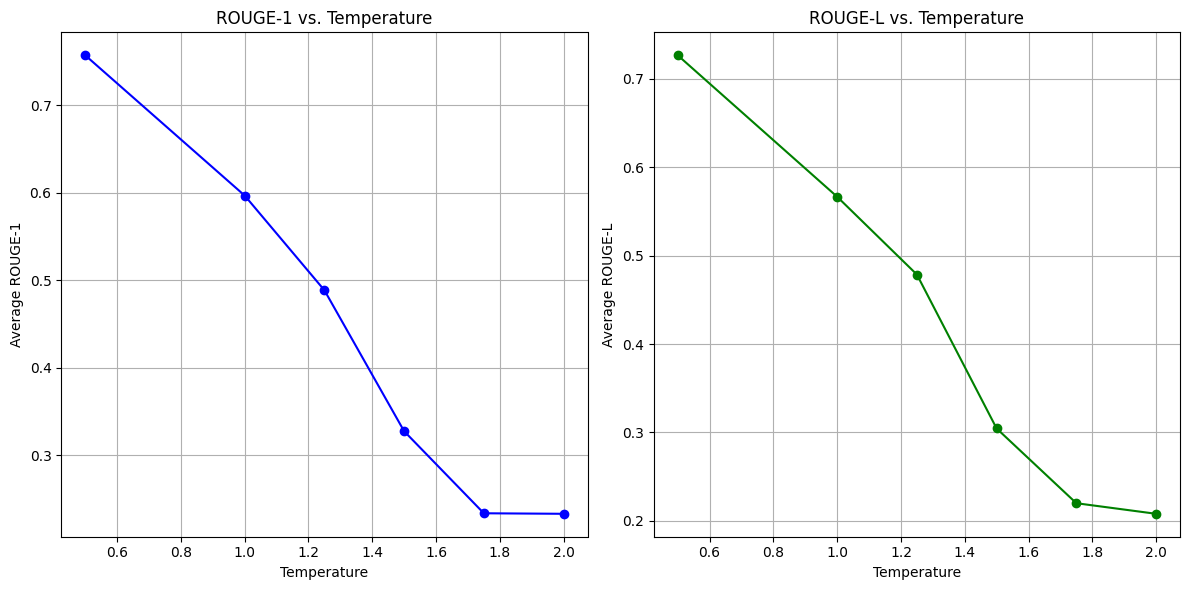

In [ ]:
temperatures = [0.5, 1.0, 1.25, 1.5, 1.75, 2.0]
plot_accuracy_vs_temperature(model, tokenizer, test_dataset.select(range(10)), device, temperatures, do_sample=True)

# Проверка обычной модели

In [ ]:
# Load model directly
from transformers import AutoModel
model = AutoModel.from_pretrained("suriya7/Gemma2B-Finetuned-Sql-Generator")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
model_path = "/content/ordinary_model"
ordinary_model = AutoModelForCausalLM.from_pretrained(model_path)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
ordinary_model.to(device)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

GemmaForCausalLM(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 2048, padding_idx=0)
    (layers): ModuleList(
      (0): GemmaDecoderLayer(
        (self_attn): GemmaAttention(
          (q_proj): lora.Linear(
            (base_layer): Linear(in_features=2048, out_features=2048, bias=False)
            (lora_dropout): ModuleDict(
              (default): Dropout(p=0.05, inplace=False)
            )
            (lora_A): ModuleDict(
              (default): Linear(in_features=2048, out_features=8, bias=False)
            )
            (lora_B): ModuleDict(
              (default): Linear(in_features=8, out_features=2048, bias=False)
            )
            (lora_embedding_A): ParameterDict()
            (lora_embedding_B): ParameterDict()
            (lora_magnitude_vector): ModuleDict()
          )
          (k_proj): Linear(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear(in_features=2048, out_features=256, bias=False)
          (o_proj): Li

In [ ]:
calculate_sql_accuracy(ordinary_model, tokenizer, test_dataset.select(range(200)), device)

Evaluating:   0%|          | 1/200 [00:15<50:59, 15.37s/it]

temperature: 1.0, model_answer: <start_of_turn>, ground_truth_query: SELECT "1st leg" FROM table_name WHERE Club = 'A.C. Libertas', natural_languge: What is the 1st leg when club is a.c. libertas?


Evaluating:   1%|          | 2/200 [00:15<21:41,  6.57s/it]

temperature: 1.0, model_answer: , ground_truth_query: SELECT 1st_leg FROM table_name WHERE 2nd_leg = 1 - 0 AND Competition = 'UEFA Champions League', natural_languge: What is the 1st leg when 2nd leg is 1–0 and competition is uefa champions league?


Evaluating:   2%|▏         | 3/200 [00:22<22:30,  6.85s/it]

temperature: 1.0, model_answer: , ground_truth_query: SELECT Competition FROM base_table WHERE 2nd_leg BETWEEN 0 AND 8;, natural_languge: What is the competition when 2nd leg is 0–8?


Evaluating:   2%|▏         | 4/200 [00:37<32:51, 10.06s/it]

temperature: 1.0, model_answer: sql select round from my_table where age between 0 and 1;, ground_truth_query: SELECT Round FROM table_name WHERE Leg_1 BETWEEN 0 AND 1;, natural_languge: What is the round when 1st leg is 0–1?


Evaluating:   2%|▎         | 5/200 [00:53<38:44, 11.92s/it]

temperature: 1.0, model_answer: , ground_truth_query: SELECT Branding FROM my_table WHERE Location = 'Metro Manila', natural_languge: What is the branding of metro manila?


Evaluating:   3%|▎         | 6/200 [01:07<41:33, 12.85s/it]

temperature: 1.0, model_answer: <start_of_turn>show
SQL Query:
SELECT COUNT(Founded) FROM table_name WHERE Institution = 'Kansas City Kansas Community College';, ground_truth_query: SELECT COUNT(Founded) FROM table WHERE Institution = 'Kansas City Kansas Community College', natural_languge: When was the institution of Kansas city Kansas community college founded?


Evaluating:   4%|▎         | 7/200 [01:17<38:30, 11.97s/it]

temperature: 1.0, model_answer: ClickHouseQuery{
select id from mascot_table where Institution = 'Kansas City Kansas Community College';, ground_truth_query: SELECT Mascot FROM table_name WHERE Institution = 'Kansas City Kansas Community College', natural_languge: What is the mascot for the instition of Kansas city Kansas community college?


Evaluating:   4%|▍         | 8/200 [01:33<41:28, 12.96s/it]

temperature: 1.0, model_answer: sql, ground_truth_query: SELECT School, Colors FROM table_name WHERE MainCampusLocation = 'Highland';, natural_languge: How many school colors is there for the main campus location of highland?


Evaluating:   4%|▍         | 9/200 [01:42<37:19, 11.72s/it]

temperature: 1.0, model_answer: A select query to convert a PostgreSQL query into a ClickHouse dialect QUERY using the PG query "SELECT Q FROM table_name WHERE Q = 'Natural_language' AND School_"Colors" = 'Blue, Red & White';, ground_truth_query: SELECT Mascot FROM table_name WHERE Founded = 1923 AND arrayExists(x -> (x IN ['Blue', 'Red', 'White']), School_Colors) =, natural_languge: What is the mascot for the school founded in 1923 with the school colors of blue, red & white?


Evaluating:   5%|▌         | 10/200 [01:42<26:09,  8.26s/it]

temperature: 1.0, model_answer: , ground_truth_query: SELECT Institution FROM table WHERE Main_Campus_Location = 'Overland Park', natural_languge: What is the instition where the main campus location is overland park?


Evaluating:   6%|▌         | 11/200 [01:57<32:33, 10.34s/it]

temperature: 1.0, model_answer: SQL
SELECT ColumnName FROM Table1 WHERE NameColumn = 'Blue Devils';, ground_truth_query: SELECT Institution FROM table WHERE Mascot = 'Blue Devils', natural_languge: What is the name of the institution with the mascot of blue devils?


Evaluating:   6%|▌         | 12/200 [02:12<37:03, 11.83s/it]

temperature: 1.0, model_answer: SELECT "Written by" FROM "my_table" WHERE "Series # ="67" ,
user
a postgres query into clickhouse dialect using pg query
CREATE TABLE IF NOT EXISTS "my_table" (CREATECREATE TABLE "my_table" (CREATECREATE COLUMN "Written by" (CREATECREATE TABLE "my_table_columns" (CREATECREATECREATECREATECREATE TABLE "my_table_columns" (SELECT TABLE "my_table" WHERE "Series #" =, ground_truth_query: SELECT Written_by FROM database.table WHERE Series = 67;, natural_languge: Name the people who wrote number 67


Evaluating:   6%|▋         | 13/200 [02:28<40:43, 13.07s/it]

temperature: 1.0, model_answer: ClickHouse code: CREATE GENERere function ClickHouseQuery(SELECT MIN(season_number) FROM seasons WHERE written_by IN (SELECT ID FROM (SELECT SEASON_number FROM seasons)) AND written_by = 'Adam Milch'};, ground_truth_query: SELECT MIN(Season) FROM table_name WHERE Written_by = 'Adam Milch';, natural_languge: Name the number of season that was written by adam milch


Evaluating:   7%|▋         | 14/200 [02:30<30:06,  9.71s/it]

temperature: 1.0, model_answer: , ground_truth_query: SELECT Season FROM table WHERE Directed_by = 'Patrick Norris', natural_languge: Name the season number for the direction of patrick norris


Evaluating:   8%|▊         | 15/200 [02:31<21:23,  6.94s/it]

temperature: 1.0, model_answer: , ground_truth_query: SELECT Writer FROM table_name WHERE Director = 'Dean White', natural_languge: Who wrote the episode when the director was dean white?


Evaluating:   8%|▊         | 16/200 [02:46<29:19,  9.56s/it]

temperature: 1.0, model_answer: , ground_truth_query: SELECT COUNT(Title) FROM your_table_name WHERE ProductionCode = 211;, natural_languge: Please list the total number of title with the production code 211.


Evaluating:   8%|▊         | 17/200 [02:48<21:49,  7.16s/it]

temperature: 1.0, model_answer: , ground_truth_query: SELECT MAX(Production_Code) FROM my_table WHERE Title = 'But There\'s Clay', natural_languge: What is the production code of the episode titled, "But there's Clay"?


Evaluating:   9%|▉         | 18/200 [03:03<29:16,  9.65s/it]

temperature: 1.0, model_answer: , ground_truth_query: SELECT Title FROM table WHERE Season = 2 AND Episode = 1, natural_languge: Please give me the title of Season 2, episode 1.


Evaluating:  10%|▉         | 19/200 [03:19<34:41, 11.50s/it]

temperature: 1.0, model_answer: <start_of_turn>, ground_truth_query: SELECT Writer FROM table WHERE Production_Code = 210, natural_languge: Provide me with the name of the writer with the production code 210.


Evaluating:  10%|█         | 20/200 [03:31<34:29, 11.50s/it]

temperature: 1.0, model_answer: , ground_truth_query: SELECT COUNT(Original_Airdate) FROM table_name WHERE Production_Code = 208;, natural_languge: What is the number of the original airdate with the production code 208.


Evaluating:  10%|█         | 21/200 [03:47<38:28, 12.90s/it]

temperature: 1.0, model_answer: CREATE schema frames per min := size_in; frame_size := frames.  CREATE SQL SELECT frame_size FROM frames   WHERE maximum_fps = 30  ; CREATE TABLE query_ClickHouse (CREATE frame_size= size_in; clickhouse_frame_size = frame_size    ); CREATE TABLE query_PostgreSQL (CREATE frame_size = size_in; pg_frame_size = frame_size    ); CREATE TABLE schema_queries (CREATE pg_, ground_truth_query: SELECT Frame_size FROM table_name WHERE Maximum_fps = 30;, natural_languge: What size is a 30 frames per minute


Evaluating:  11%|█         | 22/200 [04:03<41:20, 13.93s/it]

temperature: 1.0, model_answer: , ground_truth_query: SELECT AspectRatio FROM table_name WHERE Width > 4096.0, natural_languge: What is the size when the frame is bigger than for 4096.0


Evaluating:  12%|█▏        | 23/200 [04:19<43:00, 14.58s/it]

temperature: 1.0, model_answer: 1: SELECT compression_id FROM frames_table WHERE compression_type = 'PostgreSQL';, ground_truth_query: SELECT id, date, compression, fps, Mpix FROM table_name WHERE Mpix = 5.0 ORDER BY compression ASC, fps = 24 DESC, natural_languge: What is the smallest frames per minute when the pixels are 5.0


Evaluating:  12%|█▏        | 24/200 [04:35<43:39, 14.88s/it]

temperature: 1.0, model_answer: <begin>INSERT|ALTER|my schema|ALTER|CREATE|<end>
<start_of_turn>, ground_truth_query: SELECT Width FROM table WHERE Frame_size = '4.5K';, natural_languge: what's the width with frame size being 4.5k


Evaluating:  12%|█▎        | 25/200 [04:51<44:18, 15.19s/it]

temperature: 1.0, model_answer: , ground_truth_query: SELECT Callsign FROM ClickHouseTable WHERE Location = 'Tuguegarao';, natural_languge: What is the callsign of tuguegarao


Evaluating:  13%|█▎        | 26/200 [05:03<41:01, 14.14s/it]

temperature: 1.0, model_answer: , ground_truth_query: SELECT Station, Type FROM clickhouse_table WHERE Location = 'Calbayog' AND Type = 'Transmitter site', natural_languge: What is the station type of calbayog


Evaluating:  14%|█▎        | 27/200 [05:19<43:04, 14.94s/it]

temperature: 1.0, model_answer: , ground_truth_query: SELECT Station, Type FROM my_table WHERE Branding = 'SMNI TV-26 Naga', natural_languge: What is the station type of smni tv-26 naga


Evaluating:  14%|█▍        | 28/200 [05:35<43:33, 15.19s/it]

temperature: 1.0, model_answer: _, ground_truth_query: SELECT COUNT(Location) FROM table WHERE Callsign = 'DXCL', natural_languge: How many places featured the DXCL Callsign?


Evaluating:  14%|█▍        | 29/200 [05:51<43:56, 15.42s/it]

temperature: 1.0, model_answer: , ground_truth_query: SELECT Branding FROM table WHERE Location = 'Dagupan', natural_languge: What was the branding in Dagupan?


Evaluating:  15%|█▌        | 30/200 [06:01<39:18, 13.88s/it]

temperature: 1.0, model_answer: , ground_truth_query: SELECT Callsign FROM ClickHouseTable WHERE Location = 'Zamboanga', natural_languge: What was the callsign in Zamboanga?


Evaluating:  16%|█▌        | 31/200 [06:11<35:17, 12.53s/it]

temperature: 1.0, model_answer: sql query?Convert a PostgreSQL query into ClickHouse dialect using PG query
SELECT Power_kW FROM my_table WHERE Callsign = 'DZYT';, ground_truth_query: SELECT Power FROM table WHERE Callsign = 'DZYT', natural_languge: How much power was used when the callsign was DZYT?


Evaluating:  16%|█▌        | 32/200 [06:27<37:58, 13.56s/it]

temperature: 1.0, model_answer: <start_of_turn>, ground_truth_query: SELECT Title FROM table WHERE Season = 15;, natural_languge: What is the name of Season #15?


Evaluating:  16%|█▋        | 33/200 [06:39<36:46, 13.21s/it]

temperature: 1.0, model_answer: SQL CREATE TABLE your_table_name (PostgreSQLTable_name) IF NOT EXISTS (SELECT * FROM PostgreSQLTable_name WHERE Season_number = 18;) INSERT INTO your_table_name (POSTgreSQLTable_name) SELECT MIN(Series_number) FROM PostgreSQLTable_name WHERE Season_number = 18;, ground_truth_query: SELECT min(Series) FROM table WHERE Season = 18;, natural_languge: What is the series number for Season #18?


Evaluating:  17%|█▋        | 34/200 [06:55<38:48, 14.03s/it]

temperature: 1.0, model_answer: <start_of_turns>Select Query<end_of_turns>
<start_of_the_turn>SELECT MIN(series_number) FROM table_name WHERE written_by='Jack Orman';<end_of_the_turn>
<start_turn>SELECT MIN(series_number) FROM table_name WHERE written_by='Jack Orman';<end_turn

Query1<2071



<start_of_, ground_truth_query: SELECT MIN(Series) FROM table_name WHERE Written_by = 'Jack Orman', natural_languge: What was the first series in this list that Jack Orman wrote?


Evaluating:  18%|█▊        | 35/200 [07:05<35:17, 12.83s/it]

temperature: 1.0, model_answer: , ground_truth_query: SELECT Original_air_date FROM my_table WHERE Title = 'Responsible Parties', natural_languge: What date did the episode called "Responsible Parties" air on?


Evaluating:  18%|█▊        | 36/200 [07:15<32:43, 11.97s/it]

temperature: 1.0, model_answer: Select Title FROM movies WHERE DirectedBy= 'Richard Thorpepe';, ground_truth_query: SELECT Title FROM movies WHERE Directed_by = 'Richard Thorpe', natural_languge: What is the name of the episode that Richard Thorpe directed?


Evaluating:  18%|█▊        | 37/200 [07:31<35:52, 13.21s/it]

temperature: 1.0, model_answer: <end_of_query>
<start_of_turn>user
SELECT "Population_Maryborough" FROM my_table WHERE "Population_Woocoo" = 2700;,, ground_truth_query: SELECT Population_Maryborough FROM my_table WHERE Population_Woocoo = 2700, natural_languge: Name the population of maryborough when population of woocoo is 2700


Evaluating:  20%|█▉        | 39/200 [08:04<39:37, 14.77s/it]

temperature: 1.0, model_answer: SQL query:
SELECT crew WHERE owner = 'Bob Leavine' AND crew_chief IS NULL
SELECT crew_chief FROM crew WHERE crew_chief = 'YES', ground_truth_query: SELECT Crew_Chief FROM Crew_Chief_Table WHERE Owner = 'Bob Leavine', natural_languge: Who was crew chief for the team owned by Bob Leavine?


Evaluating:  20%|██        | 40/200 [08:04<27:51, 10.45s/it]

temperature: 1.0, model_answer: , ground_truth_query: SELECT Driver FROM table WHERE Team = 'Circle Sport', natural_languge: Who drove for team Circle Sport?


Evaluating:  20%|██        | 41/200 [08:20<32:09, 12.14s/it]

temperature: 1.0, model_answer: , ground_truth_query: SELECT Driver FROM my_table WHERE Team = 'Phil Parsons Racing', natural_languge: Who drove for Phil Parsons Racing team?


Evaluating:  21%|██        | 42/200 [08:20<22:40,  8.61s/it]

temperature: 1.0, model_answer: , ground_truth_query: SELECT Team FROM table WHERE Crew_Chief = 'Wally Rogers', natural_languge: Which teams used Wally Rogers as their crew chief?


Evaluating:  22%|██▏       | 43/200 [08:36<28:09, 10.76s/it]

temperature: 1.0, model_answer: <start_of_turn>SELECT MAX(rounds) FROM table_name WHERE Crew_Chief = 'Donnie Wingo';, ground_truth_query: SELECT max(Rounds) FROM table_name WHERE CrewChief = 'Donnie Wingo', natural_languge: What is the largest number of rounds for the team that hired Donnie Wingo as crew chief?


Evaluating:  22%|██▏       | 44/200 [08:53<32:25, 12.47s/it]

temperature: 1.0, model_answer: , ground_truth_query: SELECT Percent Change (1990–2000) FROM table WHERE 2007 Estimate = 0;, natural_languge: What is the percent change (1990–2000) when the 2007 estimate is 0 1,598,161?


Evaluating:  22%|██▎       | 45/200 [09:09<35:09, 13.61s/it]

temperature: 1.0, model_answer: SQL queries = SELECT rank FROM table_name WHERE rank = 4;, ground_truth_query: SELECT "2007 Estimate" FROM table_name WHERE "Rank (CSA)" = 4;, natural_languge: What is the 2007 estimate when the rank (csa) is 4


Evaluating:  23%|██▎       | 46/200 [09:09<24:48,  9.67s/it]

temperature: 1.0, model_answer: , ground_truth_query: SELECT "2007 Estimate" FROM clickhouse_table WHERE "Combined Statistical Area (or Metropolitan Statistical Area if noted)" = 'Tulsa-Bartlesville,, natural_languge: What is the 2007 estimate for tulsa-bartlesville, ok csa?


Evaluating:  24%|██▎       | 47/200 [09:14<20:40,  8.11s/it]

temperature: 1.0, model_answer: CREATECREATECREATECREATESELECT COUNT(*) FROM (Natural_languageg_query) WITH (PostgreSQL_query);CREATECREATECREATE–, ground_truth_query: SELECT COUNT(Population) FROM ClickHouse_Table WHERE Rank = 'MSA 348', natural_languge: How many times was the rank (csa) was (msa 348)?


Evaluating:  24%|██▍       | 48/200 [09:14<14:45,  5.83s/it]

temperature: 1.0, model_answer: , ground_truth_query: SELECT Rank, CSA FROM table_name WHERE Percent Change (1990-2000) = 'A034 +8.71%', natural_languge: What is the rank (csa) for the percentage change (1990-2000) was a034 +8.71%?


Evaluating:  24%|██▍       | 49/200 [09:30<22:20,  8.88s/it]

temperature: 1.0, model_answer: , ground_truth_query: SELECT ChampionshipName FROM championships WHERE arrayExists(x -> x = 'Genesis', PreviousChampions) = 1, natural_languge: What tourmament has Genesis won previously?


Evaluating:  25%|██▌       | 50/200 [09:46<27:22, 10.95s/it]

temperature: 1.0, model_answer: , ground_truth_query: SELECT previous_champion FROM champions WHERE champion_name = 'Xix Xavant', natural_languge: Who was the champion prior to Xix Xavant?


Evaluating:  26%|██▌       | 51/200 [10:02<31:01, 12.50s/it]

temperature: 1.0, model_answer: SELECT name FROM championships_table WHERE location = 'Ganges_Buenas, Puerto_Rico';
</start_of_turn>, ground_truth_query: SELECT Champion FROM my_table WHERE Location = 'Aguas Buenas, Puerto Rico', natural_languge: Who are the champions that have won at Aguas Buenas, Puerto Rico?


Evaluating:  26%|██▌       | 52/200 [10:19<33:46, 13.69s/it]

temperature: 1.0, model_answer: _SELECT title FROM table WHERE japanese_title = 'Ranma ½: Chougi Rambuhen';, ground_truth_query: SELECT English_Title FROM table WHERE Japanese_Title = 'Ranma ½: Chougi Rambuhen', natural_languge: What's the English translation of the Japanese title of the game Ranma ½: Chougi Rambuhen?


Evaluating:  26%|██▋       | 53/200 [10:35<35:10, 14.36s/it]

temperature: 1.0, model_answer: _type 'hot springs athletic ath tic'
SELECT Genre FROM my_table WHERE English_Title_Translation = 'Fever Ranma',
SELECT Genre FROM my_table WHERE English_Title_Translation = 'Fever Ranma',
SELECT Genre FROM my_table WHERE (SELECT Genre FROM my_table WHERE English_Title_Translation = 'Fever Ranma', SELECT Genre FROM my_table WHERE (DELETE Genre FROM my_table WHERE English_Title_Translation = 'Fever Ranma',, ground_truth_query: SELECT Genre FROM table_name WHERE English Title/Translation = 'Fever Ranma ½: Hot Springs Athletic Chapter', natural_languge: What's the genre of Fever Ranma ½: Hot Springs Athletic Chapter?


Evaluating:  27%|██▋       | 54/200 [10:39<27:41, 11.38s/it]

temperature: 1.0, model_answer: SQL query: SELECT Initial_Release_Date FROM table_name WHERE Developer = 'Microvision';, ground_truth_query: SELECT "Initial Release Date" FROM table_name WHERE Developer = 'Microvision', natural_languge: When was the game developed by Microvision released?


Evaluating:  28%|██▊       | 55/200 [10:51<27:35, 11.42s/it]

temperature: 1.0, model_answer: sql query is SELECT COUNT(Verbal_noun_stem) FROM my_table WHERE Basic_stem = '-bil-';, ground_truth_query: SELECT COUNT(Verbal_noun) FROM table WHERE Basic_stem = '-bil-';, natural_languge: What's the number of verbal nouns with the basic stem (root) -bil-?


Evaluating:  28%|██▊       | 56/200 [10:58<24:10, 10.07s/it]

temperature: 1.0, model_answer: , ground_truth_query: SELECT Meaning FROM my_table WHERE Non-present stem = '-erama-', natural_languge: What does the non-present stem -erama- mean?


Evaluating:  28%|██▊       | 57/200 [11:14<28:19, 11.88s/it]

temperature: 1.0, model_answer: pgquery = SELECT participle FROM my_table WHERE verbal_noun = 'i-bil-tze';, ground_truth_query: SELECT Participle FROM table WHERE Verbal_noun = 'i-bil-tze';, natural_languge: What's the participle when the verbal noun is i-bil-tze?


Evaluating:  29%|██▉       | 58/200 [11:24<27:08, 11.47s/it]

temperature: 1.0, model_answer: <end_of_, ground_truth_query: SELECT name FROM clickhouse_table WHERE name LIKE '%rama%', natural_languge: What does the basic stem (root) -rama- mean?


Evaluating:  30%|██▉       | 59/200 [11:25<19:13,  8.18s/it]

temperature: 1.0, model_answer: , ground_truth_query: SELECT Verbal_noun FROM table_name WHERE Participle = 'e-duki';, natural_languge: What is the verbal noun connected to the participle e-duki?


Evaluating:  30%|███       | 60/200 [11:40<24:02, 10.31s/it]

temperature: 1.0, model_answer: <!DOCTYPEsql
<!doctypesql     <!doctypesql     SQL<!doctypesql     !<end_of_sql
<!doctypesql   
<!documentsql   <!doc_sql_start  <!documentsql_start   <!_doctype sql
<!_doctype_sql     <!_   sql_end         <!_sql               <!        end           
<!_sql_end     <!     sql_start        <!        <end_turn>    <!, ground_truth_query: SELECT Tries, against FROM clickhouse_table WHERE Points = 60, natural_languge: what is the tries against where points is 60?


Evaluating:  30%|███       | 61/200 [11:56<28:11, 12.17s/it]

temperature: 1.0, model_answer: , ground_truth_query: SELECT COUNT(Losing_bonus_column_name) FROM table_name WHERE Points_against_column_name = 439;, natural_languge: How many losing bonus where there when points against is 439?


Evaluating:  31%|███       | 62/200 [12:13<30:59, 13.47s/it]

temperature: 1.0, model_answer: <, ground_truth_query: SELECT Drawn FROM table WHERE Won = 12;, natural_languge: what is the drawn when the won is 12?


Evaluating:  32%|███▏      | 63/200 [12:29<32:46, 14.36s/it]

temperature: 1.0, model_answer: , ground_truth_query: SELECT Tries as against FROM table WHERE Won = 14, natural_languge: What is the tries against when the won is 14?


Evaluating:  32%|███▏      | 64/200 [12:46<33:48, 14.91s/it]

temperature: 1.0, model_answer: UPDATE<query>SELECT COUNT(Tries) FROM table WHERE Points = 473;, ground_truth_query: SELECT COUNT(Tries) FROM table WHERE Points = 473;, natural_languge: How many tries for are for 473 points for?


Evaluating:  32%|███▎      | 65/200 [13:02<34:44, 15.44s/it]

temperature: 1.0, model_answer: select what is the points for when the played is 22 and tries against is 68,, ground_truth_query: SELECT Points, for FROM my_table WHERE Played = 22 AND Tries_against = 68;, natural_languge: what is the points for when the played is 22 and tries against is 68?


Evaluating:  33%|███▎      | 66/200 [13:19<35:10, 15.75s/it]

temperature: 1.0, model_answer: <start_of_query>
SELECT Lost FROM my_table WHERE "Try bonus" = 5 AND "Points for" = 390;
<end_of_query>
<start_of_result>
SELECT "Loss" FROM my_table WHERE ( "Try bonus" = 5 AND "Points for" = 390;
<end_of_result>, ground_truth_query: SELECT Lost FROM table WHERE Try = 5 AND Points = 390, natural_languge: what's the loss with try bonus being 5 and points for being 390


Evaluating:  34%|███▎      | 67/200 [13:35<35:16, 15.91s/it]

temperature: 1.0, model_answer: <end_of_, ground_truth_query: SELECT result FROM table_name WHERE score = 376, natural_languge: what's the win with points for being 376


Evaluating:  34%|███▍      | 68/200 [13:47<32:08, 14.61s/it]

temperature: 1.0, model_answer: sql query = SELECT WHAT's the loss with points for being 594, NATURAL languge of query: what's the loss with points for being
594, NATURAL languge of pg query: SELECT Lost FROM table_name WHERE Points = 594;, ground_truth_query: SELECT Lost FROM table_name WHERE Points = 594;, natural_languge: what's the loss with points for being 594


Evaluating:  34%|███▍      | 69/200 [13:59<30:11, 13.82s/it]

temperature: 1.0, model_answer: , ground_truth_query: SELECT Tries, against FROM table WHERE for = 47, natural_languge: what's the tries against with tries for being 47


Evaluating:  35%|███▌      | 70/200 [14:03<24:05, 11.12s/it]

temperature: 1.0, model_answer: sql query: what's the won with club?, ground_truth_query: SELECT Won FROM table_name WHERE Club = 'Ammanford RFC', natural_languge: what's the won with club being ammanford rfc


Evaluating:  36%|███▌      | 71/200 [14:19<26:59, 12.56s/it]

temperature: 1.0, model_answer: <end_of_, ground_truth_query: SELECT COUNT(Drawn) FROM table WHERE Tries = 24;, natural_languge: how many drawn with tries against being 24


Evaluating:  36%|███▌      | 72/200 [14:35<28:47, 13.50s/it]

temperature: 1.0, model_answer: SQL:
SELECT DISTINCT Query FROM my_table WHERE Points = 416;, ground_truth_query: SELECT Drawn FROM table WHERE Points = 416 AND against = 416, natural_languge: What were the drawn with points against at 416?


Evaluating:  36%|███▋      | 73/200 [14:51<30:15, 14.30s/it]

temperature: 1.0, model_answer: SELECT Won FROM my_table WHERE Triesaesues ag = 54;, ground_truth_query: SELECT Won FROM table_name WHERE Tries_against = 54;, natural_languge: What was the amount won with tries against at 54?


Evaluating:  37%|███▋      | 74/200 [14:58<25:32, 12.16s/it]

temperature: 1.0, model_answer: _statement, ground_truth_query: SELECT Lost FROM table WHERE Tries_for = Tries_for; SELECT Lost FROM table WHERE "Tries for" = "Tries for";, natural_languge: What was the lost with tries for?


Evaluating:  38%|███▊      | 75/200 [15:15<28:03, 13.47s/it]

temperature: 1.0, model_answer: <start_of_turn>user
What was the points againt when played is played?, ground_truth_query: SELECT Points, against FROM table WHERE Played = 'Played', natural_languge: What was the points againt when played is played?


Evaluating:  38%|███▊      | 76/200 [15:31<29:37, 14.33s/it]

temperature: 1.0, model_answer: SELECT Tries FROM table WHERE tries = 1 AND tries AGAINST = 2 AND tries BETWEEN = 30;, ground_truth_query: SELECT Tries FROM table WHERE Tries_against = 33;, natural_languge: What was the tries for with tries against at 33?


Evaluating:  38%|███▊      | 77/200 [15:47<30:11, 14.73s/it]

temperature: 1.0, model_answer: <script>
SELECT Played  FROM tm_tbl WHERE Club = 'Tumble RFC'; 
</script>, ground_truth_query: SELECT Played FROM my_table WHERE Club = 'Tumble RFC', natural_languge: What was the played with club tumble rfc?


Evaluating:  39%|███▉      | 78/200 [15:47<21:15, 10.45s/it]

temperature: 1.0, model_answer: , ground_truth_query: SELECT Console FROM clickhouse_table WHERE Franchise = 'Shenmue' OR Game = 'Shenmue', natural_languge: What consoles was Shenmue released on?


Evaluating:  40%|███▉      | 79/200 [16:04<24:43, 12.26s/it]

temperature: 1.0, model_answer: , ground_truth_query: SELECT main_developer FROM game_developers WHERE first_release = 1991 AND platform = 'Mega Drive/Genesis', natural_languge: Which main developer made their first release in 1991 and created the Mega Drive/Genesis console?


Evaluating:  40%|████      | 80/200 [16:09<20:35, 10.29s/it]

temperature: 1.0, model_answer: CREATECREATECREATE, ground_truth_query: SELECT COUNT(Position) FROM table WHERE CurrentClub = 'Barons Riga', natural_languge: How many players currently play for Barons Riga?


Evaluating:  40%|████      | 81/200 [16:26<23:58, 12.09s/it]

temperature: 1.0, model_answer: , ground_truth_query: SELECT Height FROM your_table_name WHERE No = 10, natural_languge: How tall was Player #10?


Evaluating:  41%|████      | 82/200 [16:42<25:57, 13.20s/it]

temperature: 1.0, model_answer: Postgres, ground_truth_query: SELECT min(Year_born) AS Min Year born FROM table_name;, natural_languge: What is the earliest any of these players were born?


Evaluating:  42%|████▏     | 83/200 [16:58<27:31, 14.12s/it]

temperature: 1.0, model_answer: # PostgreSQL Query
SELECT Player17 FROM table_name WHERE Height = 2.10;
# ClickHouse Query
SELECT player_num = 1 FROM table_name WHERE Height = '2.10.0';, ground_truth_query: SELECT No FROM table WHERE Height = 2.10, natural_languge: Which player number is 2.10 meters tall?


Evaluating:  42%|████▏     | 84/200 [17:14<28:37, 14.81s/it]

temperature: 1.0, model_answer: Select table_name, column_name FROM table_name WHERE Height = 2.12;,, ground_truth_query: SELECT Position FROM table WHERE Height = 2.12;, natural_languge: What position was played by the player who was 2.12 meters tall?


Evaluating:  42%|████▎     | 85/200 [17:15<20:09, 10.51s/it]

temperature: 1.0, model_answer: , ground_truth_query: SELECT "Current Conference" FROM ClickHouse_table WHERE Institution = "Post University";, natural_languge: What current conference is Post University a member of?


Evaluating:  43%|████▎     | 86/200 [17:15<14:12,  7.47s/it]

temperature: 1.0, model_answer: , ground_truth_query: SELECT Institution FROM table_name WHERE Nickname = 'Penmen';, natural_languge: What institution has the nickname Penmen?


Evaluating:  44%|████▎     | 87/200 [17:27<16:31,  8.77s/it]

temperature: 1.0, model_answer: <start_of_turn>user
WHERE is the University at Albany located?, ground_truth_query: SELECT Location FROM my_table WHERE Institution = 'University at Albany', natural_languge: Where is the University at Albany located?


Evaluating:  44%|████▍     | 88/200 [17:27<11:44,  6.29s/it]

temperature: 1.0, model_answer: , ground_truth_query: SELECT Classification FROM table WHERE Nickname = 'Dolphins', natural_languge: What's the classification of the institution nicknamed Dolphins?


Evaluating:  44%|████▍     | 89/200 [17:36<12:58,  7.01s/it]

temperature: 1.0, model_answer: Convert a PostgreSQL query into ClickHouse dialecting using PG query
SELECT Nickname FROM table_name WHERE Institution = 'University of Massachusetts Lowell (UMass Lowell)';, ground_truth_query: SELECT Nickname FROM table WHERE Institution = 'University of Massachusetts Lowell (UMass Lowell)';, natural_languge: What's the nickname of the University of Massachusetts Lowell (UMass Lowell)?


Evaluating:  45%|████▌     | 90/200 [17:37<09:28,  5.17s/it]

temperature: 1.0, model_answer: </code>, ground_truth_query: SELECT Position FROM table_name WHERE PlayerName = 'Ido Kozikaro', natural_languge: What is Ido Kozikaro's position?


Evaluating:  46%|████▌     | 91/200 [17:41<08:47,  4.84s/it]

temperature: 1.0, model_answer: SQL query=SELECT PlayerNAME FROM Players WHERE PlayerPosition = 'Center', ground_truth_query: SELECT PlayerName FROM player_table WHERE Position = 'Center', natural_languge: What player plays center?


Evaluating:  46%|████▌     | 92/200 [17:51<11:17,  6.28s/it]

temperature: 1.0, model_answer: SQL query What are the numbers of the players currently playing for Ironi Nahariya?,, ground_truth_query: SELECT No FROM table WHERE CurrentClub = 'Ironi Nahariya', natural_languge: What are the numbers of the players currently playing for Ironi Nahariya?


Evaluating:  46%|████▋     | 93/200 [18:07<16:40,  9.35s/it]

temperature: 1.0, model_answer: sql
SELECT name FROM players WHERE height = 2.01;, ground_truth_query: SELECT Player FROM table WHERE Height = 2.01;, natural_languge: What player is 2.01 m tall?


Evaluating:  47%|████▋     | 94/200 [18:08<11:49,  6.70s/it]

temperature: 1.0, model_answer: , ground_truth_query: SELECT Position FROM table_name WHERE Player = 'Yotam Halperin', natural_languge: What's Yotam Halperin's position?


Evaluating:  48%|████▊     | 95/200 [18:08<08:28,  4.84s/it]

temperature: 1.0, model_answer: , ground_truth_query: SELECT CurrentClub FROM ClickHouseTable WHERE YearBorn = 1984;, natural_languge: What current club does the player born in 1984 play for?


Evaluating:  48%|████▊     | 96/200 [18:25<14:24,  8.31s/it]

temperature: 1.0, model_answer: , ground_truth_query: SELECT COUNT(Height) FROM table WHERE No = 5;, natural_languge: What is the height for player number 5?


Evaluating:  48%|████▊     | 97/200 [18:41<18:28, 10.76s/it]

temperature: 1.0, model_answer: queries are currently supported.
<end_of_, ground_truth_query: SELECT Height FROM table WHERE No = 9;, natural_languge: What height is player number 9?


Evaluating:  49%|████▉     | 98/200 [18:57<21:09, 12.44s/it]

temperature: 1.0, model_answer: , ground_truth_query: SELECT COUNT(player_id) FROM players WHERE height = 2.01, natural_languge: WHat is the number for the player whose height is 2.01?


Evaluating:  50%|████▉     | 99/200 [19:14<22:53, 13.60s/it]

temperature: 1.0, model_answer: Select MIN(year_born) FROM my_table WHERE height = 2.04;, ground_truth_query: SELECT MIN(Year_born) FROM table_name WHERE Height = 2.04;, natural_languge: What year was the player with the height 2.04 born?


Evaluating:  50%|█████     | 100/200 [19:21<19:23, 11.64s/it]

temperature: 1.0, model_answer: SELECT COUNT(Height 1);, ground_truth_query: SELECT COUNT(Height) FROM table WHERE No = 8, natural_languge: How many players wore number 8?


Evaluating:  50%|█████     | 101/200 [19:37<21:34, 13.08s/it]

temperature: 1.0, model_answer: , ground_truth_query: SELECT PlayerName FROM PlayerTable WHERE YearBorn = 1983, natural_languge: What player was born in 1983?


Evaluating:  51%|█████     | 102/200 [19:43<17:47, 10.90s/it]

temperature: 1.0, model_answer: sql query = SELECT TABLE1 FROM TABLE2 WHERE TABLE1.\"QUERY_A = TABLE2.\"QUERY_A;, ground_truth_query: SELECT CurrentClub FROM players WHERE Height = 1.97, natural_languge: What club does the player who is 1.97 m tall play for?


Evaluating:  52%|█████▏    | 103/200 [19:43<12:31,  7.75s/it]

temperature: 1.0, model_answer: , ground_truth_query: SELECT COUNT(Position) FROM table WHERE CurrentClub = 'Energa Czarni', natural_languge: How many players are from energa czarni?


Evaluating:  52%|█████▏    | 104/200 [19:59<16:19, 10.21s/it]

temperature: 1.0, model_answer: SQL query: SELECT DISTINCT Year_born FROM players WHERE Player_name = 'Robert Skibniewski';, ground_truth_query: SELECT Year_born FROM players WHERE Name = 'Robert Skibniewski', natural_languge: What year was Robert Skibniewski born?


Evaluating:  52%|█████▎    | 105/200 [20:00<11:29,  7.26s/it]

temperature: 1.0, model_answer: , ground_truth_query: SELECT MIN(No) FROM my_table WHERE Player = 'Zoran Erceg', natural_languge: What No is the player Zoran Erceg


Evaluating:  53%|█████▎    | 106/200 [20:16<15:41, 10.02s/it]

temperature: 1.0, model_answer: <start_of_turn>, ground_truth_query: SELECT Icelandic FROM table WHERE Basque = 'presenta for mi locaria', natural_languge: What is the iclandic of the glossary for presenta for mi locaria


Evaluating:  54%|█████▎    | 107/200 [20:25<15:08,  9.77s/it]

temperature: 1.0, model_answer: SQL query? SELECT Icelandic_translation FROM my_table WHERE "English_translation" = "giefdu" AND "sier_socka" AND "bond", ground_truth_query: SELECT English_translation FROM table WHERE Icelandic_glossary = 'giefdu mier socka bond', natural_languge: Name the english translation of giefdu mier socka bond


Evaluating:  54%|█████▍    | 108/200 [20:42<18:11, 11.86s/it]

temperature: 1.0, model_answer: <start_of_turn>user
The translation for "219" in PostgreSQL is:
SELECT english_translation FROM dictionary WHERE word_number = 219;, ground_truth_query: SELECT English_translation FROM table_name WHERE Word_number = 219;, natural_languge: Name the english translation of 219


Evaluating:  55%|█████▍    | 109/200 [20:58<19:33, 12.90s/it]

temperature: 1.0, model_answer: , ground_truth_query: SELECT name FROM clickhouse_table WHERE id = 218;, natural_languge: Name the incelandic of the glossary for 218


Evaluating:  55%|█████▌    | 110/200 [21:05<16:43, 11.15s/it]

temperature: 1.0, model_answer: number EX Plus3?,
    PostgreSQL query: SELECT Printer_ports FROM Printer WHERE Model_number = 'EX Plus3';,
    
<start_of_turn>, ground_truth_query: SELECT Printer, ports FROM table WHERE ModelNumber = 'EX Plus3', natural_languge: What's the type of printer ports in the model number EX Plus3?


Evaluating:  56%|█████▌    | 111/200 [21:12<15:01, 10.13s/it]

temperature: 1.0, model_answer: with three parallel printer ports?,
    PostgreSQL query: SELECT, ground_truth_query: SELECT Model, Number FROM printer_table WHERE Ports = 'Three Parallel', natural_languge: What is the number of the model with three parallel printer ports?


Evaluating:  56%|█████▌    | 112/200 [21:15<11:24,  7.78s/it]

temperature: 1.0, model_answer: number?,
    PostgreSQL query: SELECT * FROM printer_ports WHERE, ground_truth_query: SELECT Printer_ports FROM table WHERE Model_number = 'EX Plus3', natural_languge: What is the type of the printer ports included in the EX Plus3 model number?


Evaluating:  56%|█████▋    | 113/200 [21:31<15:07, 10.43s/it]

temperature: 1.0, model_answer: that has been discontinued in favor of the EN1700?,
    PostgreSQL query: SELECT * FROM network_protocols WHERE notes = 'Discontinued in favor of the en1700';,
    
<start_of_turn>, ground_truth_query: SELECT Network, Protocols FROM table_name WHERE Notes = 'Discontinued in favor of the en1700', natural_languge: What are the network protocols for the model that has been discontinued in favor of the EN1700?


Evaluating:  57%|█████▋    | 114/200 [21:48<17:28, 12.19s/it]

temperature: 1.0, model_answer: , ground_truth_query: SELECT MAX(Population) FROM table_name WHERE Simplified = '铅山县', natural_languge: How many people live in 铅山县?


Evaluating:  57%|█████▊    | 115/200 [21:53<14:23, 10.16s/it]

temperature: 1.0, model_answer: , ground_truth_query: SELECT Traditional FROM table WHERE Area = 2331;, natural_languge: What is the traditional way to write the name of the district who's area is 2331?


Evaluating:  58%|█████▊    | 116/200 [22:09<16:51, 12.04s/it]

temperature: 1.0, model_answer: <end_start_of_turn>
<start_of_turn>SELECT COUNT(Pinyin) FROM my_table WHERE Simplified = "信州区"
<end_end_of_turn>
<start_of_turn>SELECT COUNT(Pinyin) FROM my_table WHERE Simplified = '信州区'
<end_end_of_turn>
<start_of_turn>SELECT COUNT(Pinyin) FROM my_table WHERE, ground_truth_query: SELECT COUNT(Pinyin) FROM table WHERE Simplified = '信州区', natural_languge: What is the capital of the district who's simplified name is 信州区?


Evaluating:  58%|█████▊    | 117/200 [22:26<18:27, 13.35s/it]

temperature: 1.0, model_answer: pgquery=SELECT Population FROM table_name WHERE Pinyin = 'Héngfēng Xiàn';, ground_truth_query: SELECT Population FROM table WHERE Pinyin = 'Héngfēng Xiàn', natural_languge: How many people live in the district who's capital is héngfēng xiàn?


Evaluating:  59%|█████▉    | 118/200 [22:42<19:29, 14.26s/it]

temperature: 1.0, model_answer: <start_of_turn>select column_names WHERE name = 'Delhi';, ground_truth_query: SELECT COUNT(Density) FROM table_name WHERE English_Name = 'Yushan County', natural_languge: What is the density of yushan county?


Evaluating:  60%|██████    | 120/200 [23:12<19:37, 14.72s/it]

temperature: 1.0, model_answer: , ground_truth_query: SELECT Gold_Medals FROM medals WHERE Total_Medals = 1, natural_languge: How many gold medals does each school who has a total of 1 medal have?


Evaluating:  60%|██████    | 121/200 [23:28<20:00, 15.20s/it]

temperature: 1.0, model_answer: , ground_truth_query: SELECT Time FROM table_name WHERE Stage = 'SS18', natural_languge: What is the time for stage ss18?


Evaluating:  61%|██████    | 122/200 [23:29<14:08, 10.88s/it]

temperature: 1.0, model_answer: <end>, ground_truth_query: SELECT Length FROM my_table WHERE Stage = 'SS22', natural_languge: Name the length for stage ss22


Evaluating:  62%|██████▏   | 123/200 [23:45<15:58, 12.45s/it]

temperature: 1.0, model_answer: , ground_truth_query: SELECT COUNT(Leg) FROM table WHERE Stage = 'SS17', natural_languge: What is the number of leg for ss17


Evaluating:  62%|██████▏   | 124/200 [23:50<12:59, 10.26s/it]

temperature: 1.0, model_answer: ClickHouse dialect
SELECT COLUMN FROM table WHERE Rallyer_name = '{{user}}.{{input}}';, ground_truth_query: SELECT Leg FROM table WHERE Rally_leader = 'C. Atkinson', natural_languge: What is the leg for c. atkinson


Evaluating:  62%|██████▎   | 125/200 [23:55<10:42,  8.56s/it]

temperature: 1.0, model_answer: , ground_truth_query: SELECT MIN(Bronze Medals) FROM table_name;, natural_languge: What's the smallest number of bronze medals that any one if the ensembles has?


Evaluating:  63%|██████▎   | 126/200 [24:11<13:26, 10.90s/it]

temperature: 1.0, model_answer: <start_of_table>table_name<end_of_table>
SELECT Rev FROM table_name WHERE Application = '2003-2004 Mustang Cobra';<end_of_table>
<start_of_table><end_of_table>
<end_of_table>, ground_truth_query: SELECT Rev FROM table WHERE Application = '2003-2004 Mustang Cobra', natural_languge: What is the rev of the 2003-2004 Mustang Cobra?


Evaluating:  64%|██████▎   | 127/200 [24:28<15:17, 12.57s/it]

temperature: 1.0, model_answer: , ground_truth_query: SELECT Rev FROM table WHERE Application = 'Aston Martin', natural_languge: What is the rev for all of the Aston Martin applications?


Evaluating:  64%|██████▍   | 128/200 [24:45<16:36, 13.84s/it]

temperature: 1.0, model_answer: SQL query
WITHERS SELECT "3rd" FROM TABLE_name WHERE "Input Splines" = 26 AND "Tag ID" = '1386-00000-0017',

SQL QUERY INSERT INTO TABLE_name (column1, column2, column3) SELECT "3rd", table_name(column1, column2, column3) WHERE "Input Splines" = 26 AND "Tag" = '1, ground_truth_query: SELECT 3rd FROM table_name WHERE "Input Splines" = 26 AND "Tag ID" = '1386-000-017', natural_languge: What is the 3rd ratio for tag number 1386-000-017 and input splines of 26?


Evaluating:  64%|██████▍   | 129/200 [24:45<11:37,  9.82s/it]

temperature: 1.0, model_answer: , ground_truth_query: SELECT 2nd FROM tablename WHERE Application = '1996-2002 Dodge Viper', natural_languge: What is the 2nd ratio of 1996-2002 Dodge Viper?


Evaluating:  65%|██████▌   | 130/200 [24:56<11:39, 10.00s/it]

temperature: 1.0, model_answer: , ground_truth_query: SELECT Application FROM database_name.table_name WHERE "6th" >= 0.50 AND "6th" <= 1 AND "Torque Rating" =, natural_languge: What application has a 6th ratio of 0.50:1 and 350 as a torque rating?


Evaluating:  66%|██████▌   | 131/200 [24:56<08:13,  7.15s/it]

temperature: 1.0, model_answer: , ground_truth_query: SELECT Client FROM table WHERE Area_of_Operation = 'EchiraX' AND Concession = 'Concession';, natural_languge: Whose address of operation was the Echirax Concession?


Evaluating:  66%|██████▌   | 132/200 [25:13<11:15,  9.93s/it]

temperature: 1.0, model_answer: , ground_truth_query: SELECT Years_of_Operation FROM my_table WHERE Area_of_Operation = 'Field_103', natural_languge: When was the operation in Field 103 executed?


Evaluating:  66%|██████▋   | 133/200 [25:29<13:09, 11.79s/it]

temperature: 1.0, model_answer: SELECT Country FROM my_table WHERE Area_of_Operation = 'El_Hamada';, ground_truth_query: SELECT Country FROM table_name WHERE "Area of Operation" = 'El Hamada', natural_languge: In what country is the El Hamada area of operation?


Evaluating:  67%|██████▋   | 134/200 [25:45<14:20, 13.04s/it]

temperature: 1.0, model_answer: , ground_truth_query: SELECT Champion FROM table WHERE 3rd pl = 4 AND 2nd pl > 4.0, natural_languge: Name the champion for 3rd place being 4 and 2nd place being larger than 4.0


Evaluating:  68%|██████▊   | 135/200 [26:01<15:16, 14.10s/it]

temperature: 1.0, model_answer: SELECT COUNT(3rd_place) AS 3rd_place FROM tablename WHERE Team = 'Ducati Xerox';, ground_truth_query: SELECT COUNT(COUNT_3rd_pl) FROM table_name WHERE team = 'Ducati Xerox', natural_languge: What is the total number for 3rd place for ducati xerox?


Evaluating:  68%|██████▊   | 136/200 [26:17<15:39, 14.67s/it]

temperature: 1.0, model_answer: <start_sentence>dialect_name
ClickHouse
<end_sentence>
<start_of_turn>query, ground_truth_query: SELECT "J.E. Armstrong" FROM table_name WHERE "W.H. Archer" = "D.M. Lawson";, natural_languge: Who is J.E. Armstrong when W.H. Archer is D.M. Lawson?


Evaluating:  68%|██████▊   | 137/200 [26:34<16:02, 15.27s/it]

temperature: 1.0, model_answer: <start_of_sql>WITH PGM_SELECT A_B AS A_O FROM A_table WHERE A_O = A_I;
SELECT A_E,B_E,C FROM A_table WHERE A_E = A_I OR B_E = B_I;
SELECT A_E,B_E,C FROM A_table WHERE A_E = A_I AND B_E = B_I;
SELECT A, ground_truth_query: SELECT F, A, Brill FROM my_table WHERE W = 'H' AND Archer = 'R' AND Newman = Brill, natural_languge: What are the fa.brill when w.h. archer is known as r. newman?


Evaluating:  69%|██████▉   | 138/200 [26:50<16:08, 15.61s/it]

temperature: 1.0, model_answer: contextual context1
<sql>select context1.table_name.from(context1);, ground_truth_query: SELECT H_L_Birkett FROM table_name WHERE W_H_Archer = R_Cochrane, natural_languge: Who is h.l birkett if w.h. archer is r. cochrane?


Evaluating:  70%|██████▉   | 139/200 [27:07<16:04, 15.81s/it]

temperature: 1.0, model_answer: , ground_truth_query: SELECT H, T, Brewer FROM table WHERE J = E AND Armstrong = Wilson, natural_languge: Who is h.t. brewer when j.e. armstrong is a.j. wilson?


Evaluating:  70%|███████   | 140/200 [27:23<15:55, 15.92s/it]

temperature: 1.0, model_answer: , ground_truth_query: SELECT H.T. Brewer FROM table WHERE J.E. Armstrong = C.P. Greeks, natural_languge: Who is h.t. brewer when je armstrong is c.p. greeks?


Evaluating:  70%|███████   | 141/200 [27:39<15:50, 16.11s/it]

temperature: 1.0, model_answer: , ground_truth_query: SELECT Part, 1 FROM table WHERE Title = 'Anxiety', natural_languge: When did the part 1 of the episode "Anxiety" air?


Evaluating:  71%|███████   | 142/200 [27:55<15:36, 16.14s/it]

temperature: 1.0, model_answer: <begin_of_turn>, ground_truth_query: SELECT Part_2 FROM table WHERE Part_1 = 'January 31, 2008', natural_languge: What was the air date of part 2 of the episode whose part 1 was aired on January 31, 2008?


Evaluating:  72%|███████▏  | 143/200 [28:11<15:15, 16.07s/it]

temperature: 1.0, model_answer: <start_of_turn>user
What's the name of the episode whose part 3 aired on February 7, 2008, 2027?, ground_truth_query: SELECT Title FROM my_table WHERE Part3 = '2008-02-07', natural_languge: What's the name of the episode whose part 3 aired on February 7, 2008?


Evaluating:  72%|███████▏  | 144/200 [28:28<15:02, 16.12s/it]

temperature: 1.0, model_answer: <start_of_turn>SELECT id FROM episodes WHERE title = 'Anxiety';
SELECT id, title, start_of_turn episode number, ground_truth_query: SELECT EpisodeNumber FROM episodes WHERE Title = 'Anxiety', natural_languge: What's the episode number of "Anxiety"?


Evaluating:  72%|███████▎  | 145/200 [28:28<10:30, 11.46s/it]

temperature: 1.0, model_answer: , ground_truth_query: SELECT Part1 FROM table_name WHERE Part2 = '2007-12-02';, natural_languge: What's the air date of part 1 of the episode whose part 2 aired on December 2, 2007?


Evaluating:  73%|███████▎  | 146/200 [28:34<08:53,  9.88s/it]

temperature: 1.0, model_answer: <start_of_turn>, ground_truth_query: SELECT COUNT(Part_Number) FROM table WHERE Episode_Number = 5, natural_languge: How many part 6 parts are there in the episode number 5?


Evaluating:  74%|███████▎  | 147/200 [28:40<07:30,  8.50s/it]

temperature: 1.0, model_answer: _language="PostgreSQL" query="SELECT record FROM team_records WHERE opponent = 'Atlanta Falcons';", ground_truth_query: SELECT Record FROM table_name WHERE Opponent = 'Atlanta Falcons', natural_languge: Name the record with opponent atlanta falcons


Evaluating:  74%|███████▍  | 148/200 [28:56<09:25, 10.88s/it]

temperature: 1.0, model_answer: sql, ground_truth_query: SELECT COUNT(Opponent) FROM table_name WHERE Game_site = 'Arrowhead Stadium', natural_languge: Name the number of opponent with arrowhead stadium


Evaluating:  74%|███████▍  | 149/200 [29:12<10:32, 12.39s/it]

temperature: 1.0, model_answer: CREATETABLE 10 CREATE TABLE 1 200 2 CREATE TABLE 20 3 3 CREATE TABLE 3 4 4 INSERT TABLE 4 5 5 INSERT TABLE 5 6 6 7 INSERT TABLE 7 8 8 9 INSERT TABLE 9 10 10CREATECREATECREATE CREATE TABLE.CREATECREATECREATECREATECREATE TABLE. TABLE create CREATE TABLE CREATE TABLE. CREATE CREATE table CREATE TABLE CREATE TABLECreate CREATE CREATE, ground_truth_query: SELECT Date FROM table_name WHERE Record = 1-0, natural_languge: Name the date with the record of 1-0


Evaluating:  75%|███████▌  | 150/200 [29:21<09:31, 11.42s/it]

temperature: 1.0, model_answer: <start_of_turn>user
Select from ClickHouse table name ClickHouse1 WHERE Date >= '2098-1-15-15';, ground_truth_query: SELECT Record FROM table WHERE Date = '1985-09-15', natural_languge: Name the record for september 15, 1985


Evaluating:  76%|███████▌  | 151/200 [29:38<10:37, 13.01s/it]

temperature: 1.0, model_answer: , ground_truth_query: SELECT COUNT(No) FROM table_name WHERE Title = 'Guerillas in the Mist', natural_languge: How many of the episodes were titled "Guerillas in the Mist"?


Evaluating:  76%|███████▌  | 152/200 [29:46<09:10, 11.46s/it]

temperature: 1.0, model_answer: What's the series number of the episodepo' is written by Elizabeth Devine?, the SQL query that retrieves records from the "series WHERE "Written by" = 'Elizabeth Devine';;, ground_truth_query: SELECT MIN(episode_no) FROM my_table WHERE written_by = 'Elizabeth Devine', natural_languge: What's the series number of the episode that's written by Elizabeth Devine?


Evaluating:  76%|███████▋  | 153/200 [30:02<10:02, 12.81s/it]

temperature: 1.0, model_answer: SELECT original_air_date FROM tv_show WHERE directed_by = 'Carey Meyer';   SELECT first_air_date FROM tv_show WHERE directed_by = 'Carey Meyer';    SELECT original_air_date FROM tv_show WHERE directed_by = 'Carey Meyer';, ground_truth_query: SELECT Original_air_date FROM TableName WHERE Directed_by = 'Carey Meyer', natural_languge: When was the episode directed by Carey Meyer aired for the first time?


Evaluating:  77%|███████▋  | 154/200 [30:18<10:35, 13.82s/it]

temperature: 1.0, model_answer: <start_of_turn>user
What is the PostgreSQL query from PostgreSQL that converts the query into the ClickHouse dialect?, ground_truth_query: SELECT Written by FROM clickhouse_table WHERE Title = 'Ambush', natural_languge: Who is the writer of the episode called "Ambush" (part 1)?


Evaluating:  78%|███████▊  | 155/200 [30:34<10:52, 14.49s/it]

temperature: 1.0, model_answer: 201, ground_truth_query: SELECT Office FROM table_name WHERE Incumbent = 'Ramon R. Jimenez, Jr.';, natural_languge: who is the the office with incumbent being ramon r. jimenez, jr.


Evaluating:  78%|███████▊  | 156/200 [30:34<07:31, 10.27s/it]

temperature: 1.0, model_answer: , ground_truth_query: SELECT COUNT(Office) FROM table_name WHERE Department = 'Department of Justice Kagawaran ng Katarungan', natural_languge: how many office with department being department of justice kagawaran ng katarungan


Evaluating:  78%|███████▊  | 157/200 [30:50<08:37, 12.02s/it]

temperature: 1.0, model_answer: , ground_truth_query: SELECT Department FROM ClickHouseTable WHERE Acronym = 'DepEd (KEd)', natural_languge: what's the department with acronym being deped (ked)


Evaluating:  79%|███████▉  | 158/200 [31:07<09:18, 13.29s/it]

temperature: 1.0, model_answer: , ground_truth_query: SELECT Department FROM my_table WHERE Incumbent = 'Enrique Ona', natural_languge: what's the department with incumbent being enrique ona


Evaluating:  80%|███████▉  | 159/200 [31:23<09:36, 14.06s/it]

temperature: 1.0, model_answer: <start_of_turn>user
Select the most suitable Clickhouse dialect query:, ground_truth_query: SELECT Acronym FROM table_name WHERE Department = 'Department of Finance Kagawaran ng Pananalapi';, natural_languge: what's the acronym with department being department of finance kagawaran ng pananalapi


Evaluating:  80%|████████  | 160/200 [31:38<09:41, 14.54s/it]

temperature: 1.0, model_answer: , ground_truth_query: SELECT original_air_date FROM episodes WHERE title = 'Hell Bent for Leather', natural_languge: When did the episode "Hell bent for leather" originally air?


Evaluating:  80%|████████  | 161/200 [31:39<06:42, 10.32s/it]

temperature: 1.0, model_answer: , ground_truth_query: SELECT min("No. in season") FROM table_name WHERE Title = 'Quitters', natural_languge: What's the season number of the episode titled "Quitters"?


Evaluating:  81%|████████  | 162/200 [31:39<04:40,  7.39s/it]

temperature: 1.0, model_answer: , ground_truth_query: SELECT MAX(episode_id) AS "No. in season" FROM your_table_name WHERE viewers_million = 0.57, natural_languge: What's the season number of the episode watched by 0.57 million US viewers?


Evaluating:  82%|████████▏ | 163/200 [31:40<03:15,  5.29s/it]

temperature: 1.0, model_answer: , ground_truth_query: SELECT COUNT(Original_air_date) FROM your_table_name WHERE US_viewers_million = 0.67;, natural_languge: How many episodes were seen by 0.67 million US viewers on their original air dates?


Evaluating:  82%|████████▏ | 164/200 [31:40<02:17,  3.82s/it]

temperature: 1.0, model_answer: , ground_truth_query: SELECT Title FROM movies WHERE DirectedBy = 'David Duchovny', natural_languge: What episode was directed by David Duchovny?


Evaluating:  82%|████████▎ | 165/200 [31:56<04:23,  7.52s/it]

temperature: 1.0, model_answer: , ground_truth_query: SELECT Purse FROM ClickHouseTable WHERE Margin_of_victory = 1;, natural_languge: How much is the purse ( $ ) when the margin of victory is 1 stroke?


Evaluating:  83%|████████▎ | 166/200 [32:12<05:41, 10.03s/it]

temperature: 1.0, model_answer: sql postgres 'ClickHouse' query PG_query 'SELECT par FROM results WHERE Country = 'Mexico'' and Winning_score = '67-67-69-70=273'';, ground_truth_query: SELECT To, par FROM table_name WHERE Country = 'Mexico' AND Winning_score = '67-67-69-70=273', natural_languge: What is the number of "to par" in Mexico with a winning score of 67-67-69-70=273?


Evaluating:  84%|████████▎ | 167/200 [32:28<06:31, 11.86s/it]

temperature: 1.0, model_answer: , ground_truth_query: SELECT 3rd day FROM table_name WHERE 4th day = 'rowed-over', natural_languge: what's the 3rd day with 4th day being rowed-over


Evaluating:  84%|████████▍ | 168/200 [32:44<06:55, 12.99s/it]

temperature: 1.0, model_answer: , ground_truth_query: SELECT 3rd_day FROM table WHERE Finish_position = 16;, natural_languge: what's the 3rd day with finbeingh position being 16th


Evaluating:  84%|████████▍ | 169/200 [32:58<06:50, 13.23s/it]

temperature: 1.0, model_answer: = ClickHouse;, ground_truth_query: SELECT count_1st_day FROM table_name WHERE "3rd_day" = "bumped St_Catherines", natural_languge: how many 1st day with 3rd day being bumped st. catharine's


Evaluating:  85%|████████▌ | 170/200 [33:14<07:04, 14.16s/it]

temperature: 1.0, model_answer: 0, ground_truth_query: SELECT COUNT(3rd_day) FROM ClickHouse_Table WHERE 2nd_day = 'bumped by Magdalene', natural_languge: how many 3rd day with 2nd day being bumped by magdalene


Evaluating:  86%|████████▌ | 171/200 [33:29<07:01, 14.53s/it]

temperature: 1.0, model_answer: SQL query postgres1, ground_truth_query: SELECT "4th Day" FROM table WHERE "3rd Day" = 'bumped by Downing', natural_languge: what's the 4th day with 3rd day being bumped by downing


Evaluating:  86%|████████▌ | 172/200 [33:45<06:57, 14.91s/it]

temperature: 1.0, model_answer: , ground_truth_query: SELECT MAX(Year) FROM table WHERE Day = 3;, natural_languge: what is the maximum year with 3rd day being rowed-over


Evaluating:  86%|████████▋ | 173/200 [33:46<04:46, 10.60s/it]

temperature: 1.0, model_answer: , ground_truth_query: SELECT Result FROM table_name WHERE District = 'New York 6';, natural_languge: what are all the result for New York 6 district


Evaluating:  87%|████████▋ | 174/200 [33:46<03:15,  7.53s/it]

temperature: 1.0, model_answer: , ground_truth_query: SELECT Candidates FROM table_name WHERE Incumbent = 'Gregory W. Meeks', natural_languge: Who were the candidates when gregory w. meeks was the incumbent


Evaluating:  88%|████████▊ | 175/200 [34:02<04:10, 10.03s/it]

temperature: 1.0, model_answer: <start_of_turn>SELECT DISTRICT FROM my_table WHERE District = 'New York 16' INSERT pg_query.sql;, ground_truth_query: SELECT Result FROM clickhouse_table WHERE District = 'New York' AND CityID = 16;, natural_languge: what are all the result for New York 16 district


Evaluating:  88%|████████▊ | 176/200 [34:07<03:23,  8.50s/it]

temperature: 1.0, model_answer: SQL=, ground_truth_query: SELECT Result FROM my_table WHERE District = 'New York' AND Number = 7;, natural_languge: what are all the result for New York 7 district


Evaluating:  88%|████████▊ | 177/200 [34:07<02:20,  6.10s/it]

temperature: 1.0, model_answer: , ground_truth_query: SELECT Party FROM table_name WHERE Incumbent = 'Kevin Brady', natural_languge: What party was Kevin Brady?


Evaluating:  89%|████████▉ | 178/200 [34:23<03:18,  9.04s/it]

temperature: 1.0, model_answer: sql Convert PG query into ClickHouse dialect, ground_truth_query: SELECT District FROM my_table WHERE Incumbent = 'Ron Paul', natural_languge: What district has Ron Paul?


Evaluating:  90%|████████▉ | 179/200 [34:24<02:15,  6.44s/it]

temperature: 1.0, model_answer: , ground_truth_query: SELECT Party FROM table_name WHERE Incumbent = 'Jim Ramstad';, natural_languge: What party does jim ramstad represent?


Evaluating:  90%|█████████ | 180/200 [34:39<03:02,  9.15s/it]

temperature: 1.0, model_answer: <start_of_turn>SELECT MIN(First_elected) FROM table_name WHERE Incumbent = 'Jim Ramstad';, ground_truth_query: SELECT MIN(First_elected) FROM table_name WHERE Incumbent = 'Jim Ramstad', natural_languge: What year was incumbent jim ramstad first elected?


Evaluating:  90%|█████████ | 181/200 [34:55<03:32, 11.16s/it]

temperature: 1.0, model_answer: , ground_truth_query: SELECT Results FROM table WHERE Incumbent = 'Gil Gutknecht', natural_languge: What was the result when incumbent gil gutknecht ran?


Evaluating:  91%|█████████ | 182/200 [35:12<03:50, 12.79s/it]

temperature: 1.0, model_answer: , ground_truth_query: SELECT max(First elected) FROM table_name WHERE Incumbent = 'Sherrod Brown', natural_languge: When was the incumbent Sherrod Brown first elected?


Evaluating:  92%|█████████▏| 183/200 [35:12<02:34,  9.11s/it]

temperature: 1.0, model_answer: , ground_truth_query: SELECT Results FROM table WHERE First_elected = 1984, natural_languge: What was the result of the election in which the incumbent was first elected in 1984?


Evaluating:  92%|█████████▏| 184/200 [35:28<02:57, 11.12s/it]

temperature: 1.0, model_answer: <start_of_turn>, ground_truth_query: SELECT Incumbent FROM table WHERE First_elected = 1972, natural_languge: Which incumbent was first elected in 1972?


Evaluating:  92%|█████████▎| 185/200 [35:33<02:22,  9.47s/it]

temperature: 1.0, model_answer: SELECT * FROM Candidates WHERE party = 'Tony P. Hall';, ground_truth_query: SELECT Candidates FROM table WHERE Incumbent = 'Tony P. Hall', natural_languge: Tony P. Hall was the incumbent in the race between what two candidates?


Evaluating:  93%|█████████▎| 186/200 [35:39<01:56,  8.30s/it]

temperature: 1.0, model_answer: <end_start_of_turn>, ground_truth_query: SELECT District FROM table_name WHERE Incumbent = 'Marcia C. Kaptur', natural_languge: In which district is the incumbent Marcia C. Kaptur?


Evaluating:  94%|█████████▎| 187/200 [35:55<02:17, 10.56s/it]

temperature: 1.0, model_answer: _name = "table_name";,, ground_truth_query: SELECT MIN(First_elected) FROM table_name WHERE Result = 'Retired' AND Republican_hold = 'Republican_hold', natural_languge: What is the earliest year where the result of the election was a retired republican hold?


Evaluating:  94%|█████████▍| 188/200 [35:56<01:31,  7.59s/it]

temperature: 1.0, model_answer: SQL, ground_truth_query: SELECT Party FROM my_table WHERE Incumbent = 'Thomas Foglietta', natural_languge: What party is thomas foglietta from?


Evaluating:  94%|█████████▍| 189/200 [36:11<01:49, 10.00s/it]

temperature: 1.0, model_answer: ClickHouse     <end_of_, ground_truth_query: SELECT Opponent FROM table_name WHERE District = 'Ohio12', natural_languge: who is the the opponent with district being ohio12


Evaluating:  95%|█████████▌| 190/200 [36:27<01:57, 11.74s/it]

temperature: 1.0, model_answer: SELECT Party FROM my_table WHERE opponent = 'Mike Oxley (R)';, ground_truth_query: SELECT Party FROM table_name WHERE Opponent = 'Mike Oxley (R) unopposed', natural_languge: what's the party with opponent being mike oxley (r) unopposed


Evaluating:  96%|█████████▌| 191/200 [36:28<01:15,  8.40s/it]

temperature: 1.0, model_answer: , ground_truth_query: SELECT Party FROM table_name WHERE Opponent = 'Marcy Kaptur (D)';, natural_languge: what's the party with opponent being marcy kaptur (d) 75.3% randy whitman (r) 24.7%


Evaluating:  96%|█████████▌| 192/200 [36:44<01:26, 10.81s/it]

temperature: 1.0, model_answer: CREATE CREATE TABLE Parties_deborah (p) CREATE CREATE TABLE Match_deborah (ph,s) CREATE TABLE Rngle_players (ps,s,n) WITH MATCH Rngle_players (ph,s,n), JOIN MATCH Rngle_players (ph,s), WHERE Party_name = 'Deborah Pryce (R) 70.7%) BILL Buckel (D) 29.1%), JOIN MATCH Rng, ground_truth_query: SELECT Party FROM table_name WHERE Opponent = 'Deborah Pryce (R)' AND Percentage = 70.7% OR Opponent = 'Bill Buck, natural_languge: what's the party with opponent being deborah pryce (r) 70.7% bill buckel (d) 29.1%


Evaluating:  96%|█████████▋| 193/200 [37:01<01:27, 12.54s/it]

temperature: 1.0, model_answer: , ground_truth_query: SELECT count(Status) FROM table_name WHERE First_elected = 1968;, natural_languge: how many status with first elected being 1968


Evaluating:  97%|█████████▋| 194/200 [37:17<01:22, 13.76s/it]

temperature: 1.0, model_answer: sql SELECT First Elected Elected 'Ralph Regula'
 (r) 75.0% from election_results WHERE candidate_name = 'Ralph Regula' AND percentage = 75.0% UNION SELECT First Elected 'Michael Finn' (d) 25.0% FROM election_results WHERE candidate_name = 'Michael Finn' UNION SELECT First Elected 'Ralph Regula' (r) 75.0% FROM election_results WHERE candidate_name = 'Ralph Regula, ground_truth_query: SELECT First, Elected FROM table_name WHERE Opponent = 'Ralph Regula' AND Percentage = 75.0% UNION ALL SELECT First, Elected FROM, natural_languge: what's the first elected with opponent being ralph regula (r) 75.0% j. michael finn (d) 25.0%


Evaluating:  98%|█████████▊| 195/200 [37:34<01:13, 14.63s/it]

temperature: 1.0, model_answer: , ground_truth_query: SELECT District FROM table WHERE First_elected = 1978;, natural_languge: What district first elected in 1978?


Evaluating:  98%|█████████▊| 196/200 [37:43<00:52, 13.03s/it]

temperature: 1.0, model_answer: , ground_truth_query: SELECT District FROM table WHERE Incumbent = 'Jerry Kleczka';, natural_languge: What district was incumbent Jerry Kleczka in?


Evaluating:  98%|█████████▊| 197/200 [37:59<00:41, 13.75s/it]

temperature: 1.0, model_answer: , ground_truth_query: SELECT COUNT(Result) FROM table_name WHERE Incumbent = 'Toby Roth', natural_languge: How many districts had results related to incumbent Toby Roth?


Evaluating:  99%|█████████▉| 198/200 [38:15<00:28, 14.50s/it]

temperature: 1.0, model_answer: sql query = ClickHouse.qls.PostgreSQL.query;
<end_of_end_of_turn>
<start_of_turn>user
You are an intelligent AI specialized in generating SQL queries.
Your task is to assist users in formulating SQL queries to retrieve specific information from a database.
Please provide the SQL query corresponding to the given prompt and context:, ground_truth_query: SELECT * FROM Candidates WHERE district = 'Wisconsin 1', natural_languge: Who were the candidates in district Wisconsin 1?


Evaluating: 100%|█████████▉| 199/200 [38:32<00:15, 15.22s/it]

temperature: 1.0, model_answer: INSERTSELECT Districtīrāt FROM my_table WHERE Inlumbent = 'Lawrence J. Smith';, ground_truth_query: SELECT District FROM my_table WHERE Incumbent = 'Lawrence J. Smith', natural_languge: Name the district of lawrence j. smith


Evaluating: 100%|██████████| 200/200 [38:48<00:00, 11.64s/it]

temperature: 1.0, model_answer: <insert_1954>WITH POSTGRES , CREATE TABLE table_name , INSERT INCumbent FROM table_name WHERE First_elected = 1954;, ground_truth_query: SELECT Incumbent FROM table WHERE First_elected = 1954;, natural_languge: Name the incumbent for 1954


0.01

In [ ]:
calculate_sql_rouge(ordinary_model, tokenizer, test_dataset.select(range(200)), device)

Evaluating: 100%|██████████| 200/200 [44:51<00:00, 13.46s/it]

Average ROUGE-1: 0.14538157802783735
Average ROUGE-L: 0.13766008715960734


(0.14538157802783735, 0.13766008715960734)